In [ ]:
#!/usr/bin/env python3

import os
from random import randint, random

import h5py
import numpy as np
from PIL import Image, ImageDraw


def generate(dir_name, num_imgs):
    # `torchvision.datasets.ImageFolder` requires a subfolder
    os.makedirs(f'./msds1/{dir_name}/0', exist_ok=True)

    labels = np.empty((num_imgs, 4, 4, 6), dtype=np.int32)
    for count in range(num_imgs):
        item_color = (
            randint(0, 191) + 32,
            randint(0, 191) + 32,
            randint(0, 191) + 32,
        )

        img = Image.new('RGB', (32, 32), (0, 0, 0))
        for i in range(4):
            for j in range(4):
                item = Image.new('RGBA', (8, 8), (255, 255, 255, 0))
                draw = ImageDraw.Draw(item)

                now_color = (
                    item_color[0] + randint(-32, 32),
                    item_color[1] + randint(-32, 32),
                    item_color[2] + randint(-32, 32),
                    255,
                )
                draw.ellipse((1, 3, 7, 5), now_color)
                now_angle = random() * 180
                item = item.rotate(now_angle,
                                   resample=Image.Resampling.BICUBIC)

                now_pos = (
                    i * 8 + randint(-1, 1),
                    j * 8 + randint(-1, 1),
                )
                img.paste(item, now_pos, mask=item)

                label = now_pos + (now_angle, ) + now_color[:3]
                labels[count, i, j, :] = label

        img.save(f'./msds1/{dir_name}/0/{count:05d}.png', compress_level=1)

    with h5py.File(f'./msds1/{dir_name}_labels.hdf5', 'w') as f:
        f.create_dataset('labels',
                         data=labels,
                         compression='gzip',
                         shuffle=True)


def main():
    generate('train', 9 * 10**4)
    generate('test', 10**4)


if __name__ == '__main__':
    main()

In [ ]:
# msds1_dataset.py
import os
from pathlib import Path
from typing import Tuple, Optional, Callable

import h5py
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset

batch_size = 512

class MSDS1(Dataset):
    """
    Minimal PyTorch-style wrapper around the dataset generated by your script.

    • Each sample returns:
        img   –   torch.Tensor   (C, H, W)   –   by default in [0,1]
        label –   torch.Tensor   (4, 4, 6)   –   (x, y, angle, R, G, B)
    """

    def __init__(
        self,
        root: str | Path = "./msds1",
        split: str = "train",            # "train" | "test"
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        preload_labels: bool = True,     # load the entire HDF5 once; fine for 90k × 96 ints ≈ 35 MB
    ):
        super().__init__()

        split = split.lower()
        if split not in {"train", "test"}:
            raise ValueError(f"split must be 'train' or 'test', got {split!r}")

        self.img_dir = Path(root) / split / "0"
        self.img_paths = sorted(self.img_dir.glob("*.png"))          # 00000.png, 00001.png, …
        if not self.img_paths:
            raise FileNotFoundError(f"No images found in {self.img_dir}")

        # ------ labels ------------------------------------------------------
        h5_path = Path(root) / f"{split}_labels.hdf5"
        if not h5_path.exists():
            raise FileNotFoundError(h5_path)

        if preload_labels:
            with h5py.File(h5_path, "r") as f:
                self.labels = torch.from_numpy(f["labels"][...])     # (N, 4, 4, 6)
        else:
            # keep only the path; open lazily in __getitem__
            self.labels = None
            self._h5_path = h5_path

        # ------ optional transforms ----------------------------------------
        from torchvision.transforms import ToTensor
        self.transform = transform or ToTensor()
        self.target_transform = target_transform

    def __len__(self) -> int:
        return len(self.img_paths)

    # --------------------------------------------------------------------- #
    def _lazy_load_label(self, idx: int) -> torch.Tensor:
        """Open the HDF5 file every time (safer with num_workers>0)."""
        with h5py.File(self._h5_path, "r") as f:
            arr = f["labels"][idx]                   # (4, 4, 6) ndarray
        return torch.from_numpy(arr)

    # --------------------------------------------------------------------- #
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        # --- image ---------------------------------------------------------
        img = Image.open(self.img_paths[idx]).convert("RGB")         # (32×32)
        if self.transform:
            img = self.transform(img)                                # torch.FloatTensor

        # --- label ---------------------------------------------------------
        if self.labels is not None:                                  # pre-loaded
            target = self.labels[idx]
        else:                                                        # lazy path
            target = self._lazy_load_label(idx)

        if self.target_transform:
            target = self.target_transform(target)

        return img, target


In [ ]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose

# -- transforms --------------------------------------------------------------
transforms = Compose([
    ToTensor()                         # PIL → [0,1] tenso
])

# -- datasets & loaders ------------------------------------------------------
train_ds = MSDS1(root="./msds1", split="train", transform=transforms)
test_ds  = MSDS1(root="./msds1", split="test",  transform=transforms)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

# ---- quick sanity check ----------------------------------------------------
images, labels = next(iter(train_loader))
print(images.shape)   # torch.Size([128, 3, 32, 32])
print(labels.shape)   # torch.Size([128, 4, 4, 6])


torch.Size([512, 3, 32, 32])
torch.Size([512, 4, 4, 6])


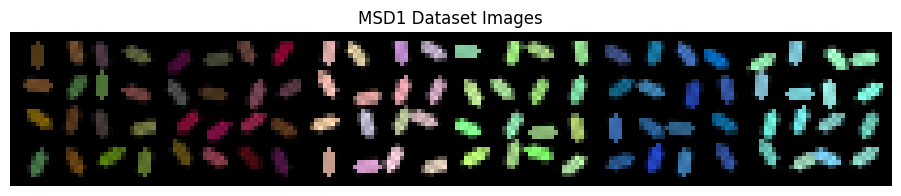

In [ ]:
import matplotlib.pyplot as plt
import torchvision

def show_images(data_loader, num_images: int = 6, *, denorm=None):
    """
    Visualise `num_images` images from the first batch in `data_loader`.

    Args
    ----
    data_loader : torch.utils.data.DataLoader
        Your existing loader (train or val).
    num_images  : int
        How many images from the batch to plot (<= batch_size).
    denorm : callable or None
        Optionally reverse any normalisation applied in your transforms.
        Example:
            denorm = lambda x: x * 0.5 + 0.5        # if you used Normalize(mean=.5, std=.5)
    """

    images, labels = next(iter(data_loader))
    images = images[:num_images].cpu()

    if denorm is not None:
        images = denorm(images)

    # torchvision.utils.make_grid puts them into one canvas
    grid = torchvision.utils.make_grid(
        images, nrow=num_images, padding=2, normalize=False
    )
    grid = grid.permute(1, 2, 0).numpy()           # (C,H,W) → (H,W,C) for matplotlib

    plt.figure(figsize=(2 * num_images, 2))
    plt.imshow(grid)
    plt.title(f"MSD1 Dataset Images")
    plt.axis("off")
    plt.show()
show_images(train_loader)

In [ ]:
from torch.nn import init
from torch.utils.checkpoint import checkpoint
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import torch.distributions as D
import os
from torch.nn.utils.parametrizations import weight_norm
from torch.profiler import profile, record_function, ProfilerActivity, schedule
from contextlib import nullcontext # Used to conditionally disable the profiler
from torch.utils.checkpoint import checkpoint
from math import sqrt, log
from typing import List, Tuple, Dict, Any, Optional, Union
import time
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_float32_matmul_precision('high')

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from math import sqrt


class Swish(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(num_features))

    def forward(self, x):
        return x * torch.sigmoid(self.alpha * x)


class ResNet(nn.Module):
    def __init__(self, nres = 4, widths = [48, 512, 512, 48], final_scale = True):
        assert widths[0] == widths[-1]

        super().__init__()
        self.res_blocks = nn.ModuleList(
            [self.build_res_block(widths) for _ in range(nres)])

        if final_scale:
            self.scale = nn.Parameter(torch.zeros(widths[-1]))
        else:
            self.scale = None

    def build_linear(self, in_features, out_features):
        linear = nn.Linear(in_features, out_features)
        bound = sqrt(2.81 * 3 / in_features)
        nn.init.uniform_(linear.weight, -bound, bound)
        nn.init.zeros_(linear.bias)
        linear = weight_norm(linear)
        return linear

    def build_res_block(self, widths):
        layers = []
        for i in range(len(widths) - 1):
            layers.append(Swish(widths[i]))
            layers.append(self.build_linear(widths[i], widths[i + 1]))
        return nn.Sequential(*layers)

    def forward(self, x):
        for res_block in self.res_blocks:
            x = (x + res_block(x)) / sqrt(2)

        if self.scale is not None:
            x = x * self.scale

        return x


class ResidualNetwork(ResNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        shape = x.shape  # (B*num_RG_blocks, C, K, K)
        x = x.view(shape[0], -1)  # (B*num_RG_blocks, C*K*K)
        x = super().forward(x)
        x = x.view(shape)
        return x

In [ ]:
def create_masks(kernel_size: int, num_channels:int) -> Tuple[torch.Tensor, torch.Tensor]:
    '''
    Create checkerboard masks for the RNVP block.
    Args:
        kernel_size: The size of the kernel
        num_channels: The number of channels in the input
    Returns:
        mask: The mask for the networks
        comask: The complementary mask such that mask + comask = 1
    '''
    checkerboard = torch.from_numpy(np.indices((kernel_size, kernel_size)).sum(axis=0) % 2).float()
    mask = checkerboard.unsqueeze(0).repeat(num_channels, 1, 1)
    comask = 1 - mask
    return mask, comask

class RNVPBlock(nn.Module):
    mask: torch.Tensor
    comask: torch.Tensor

    def __init__(
        self,
        kernel_size: int,
        num_channels: int,
        s_nets: List[nn.Module],
        t_nets: List[nn.Module],
        *,
        apply_tanh: bool = True,
        use_ckpt: bool  = True,
    ):
        super().__init__()
        assert len(s_nets) == len(t_nets), "Need the same number of s and t networks"
        self.s_nets  = nn.ModuleList(s_nets)
        self.t_nets  = nn.ModuleList(t_nets)
        self.apply_tanh = apply_tanh
        self.use_ckpt   = use_ckpt

        mask, comask = create_masks(kernel_size, num_channels)
        self.register_buffer("mask",   mask)        # (C,H,W)
        self.register_buffer("comask", comask)


    def _checkpoint(self, fn, x):
        if self.training and self.use_ckpt and x.requires_grad:
            return checkpoint(fn, x, use_reentrant=False)   # saves memory
        else:
            return fn(x)

    def _one_forward_flow(
        self, x: torch.Tensor, s_net: nn.Module, t_net: nn.Module
    ) -> Tuple[torch.Tensor, torch.Tensor]:

        x1, x2 = x * self.mask, x * self.comask

        # step 1: mask -> comask
        s1 = self.comask * self._checkpoint(s_net, x1)
        t1 = self.comask * self._checkpoint(t_net, x1)
        if self.apply_tanh:  s1 = torch.tanh(s1)
        x2_ = self.comask * (torch.exp(s1) * x2 + t1)
        ldj  = s1.sum(dim=(1, 2, 3))

        # step 2: comask -> mask
        s2 = self.mask * self._checkpoint(s_net, x2_)
        t2 = self.mask * self._checkpoint(t_net, x2_)
        if self.apply_tanh:  s2 = torch.tanh(s2)
        x1_ = self.mask * (torch.exp(s2) * x1 + t2)
        ldj += s2.sum(dim=(1, 2, 3))

        return x1_ + x2_, ldj

    def _one_inverse_flow(
        self, x: torch.Tensor, s_net: nn.Module, t_net: nn.Module
    ) -> Tuple[torch.Tensor, torch.Tensor]:

        x1, x2 = x * self.mask, x * self.comask

        # step 2⁻¹
        s2 = self.mask * self._checkpoint(s_net, x2)
        t2 = self.mask * self._checkpoint(t_net, x2)
        if self.apply_tanh:  s2 = torch.tanh(s2)
        x1_ = self.mask * torch.exp(-s2) * (x1 - t2)
        ldj  = -s2.sum(dim=(1, 2, 3))

        # step 1⁻¹
        s1 = self.comask * self._checkpoint(s_net, x1_)
        t1 = self.comask * self._checkpoint(t_net, x1_)
        if self.apply_tanh:  s1 = torch.tanh(s1)
        x2_ = self.comask * torch.exp(-s1) * (x2 - t1)
        ldj -= s1.sum(dim=(1, 2, 3))

        return x1_ + x2_, ldj

    def forward(self, x):
        ldj = torch.zeros(x.size(0), device=x.device)
        for s_net, t_net in zip(self.s_nets, self.t_nets):
            x, inc = self._one_forward_flow(x, s_net, t_net)
            ldj += inc
        return x, ldj

    def inverse(self, z):
        ldj = torch.zeros(z.size(0), device=z.device)
        for s_net, t_net in zip(reversed(self.s_nets), reversed(self.t_nets)):
            z, inc = self._one_inverse_flow(z, s_net, t_net)
            ldj += inc
        return z, ldj


In [ ]:
def shift_kernel_blocks(x: torch.Tensor, m: int, h:int, inverse : bool = False) -> torch.Tensor:
    shift = (m // 2) * (2 ** h)
    if not inverse:
        return torch.roll(x, shifts=(-shift, -shift), dims=(-2, -1))
    else:
        return torch.roll(x, shifts=(shift, shift), dims=(-2, -1))

class MERABlock(nn.Module):
    def __init__(self, m, h, network, shift=False):
        super().__init__()
        self.m = m
        self.h = h
        self.network = network # Should have forward and inverse methods
        self.dilation = 2 ** h
        self.stride = m * self.dilation
        self.unfold = nn.Unfold(kernel_size=m, dilation=self.dilation, stride=self.stride)
        self.fold = None
        self.shift = shift
        self.cached_mask = None

    def _apply_flow(self, x, flow_method):
        B, C, H, W = x.shape

        x_orig = x
        x_to_process = x
        if self.shift:
            x_to_process = shift_kernel_blocks(x, self.m, self.h)

        patches = self.unfold(x_to_process)

        num_patches = patches.shape[-1]
        patches_reshaped = patches.view(B, C, self.m, self.m, num_patches).permute(0, 4, 1, 2, 3).reshape(B * num_patches, C, self.m, self.m)

        # Apply the specified flow method (forward or inverse)
        transformed_patches, ldj = flow_method(patches_reshaped)

        transformed_patches_reshaped = transformed_patches.view(B, num_patches, C, self.m, self.m).permute(0, 2, 3, 4, 1).reshape(B, C * self.m * self.m, num_patches)

        if self.fold is None:
            self.fold = nn.Fold(output_size=(H, W), kernel_size=self.m, dilation=self.dilation, stride=self.stride)
            with torch.no_grad():
                single_item_patches = patches.narrow(0, 0, 1)
                self.cached_mask = self.fold(torch.ones_like(single_item_patches))

        folded = self.fold(transformed_patches_reshaped)

        mask = self.cached_mask.expand(B, C, H, W)

        if self.shift:
            folded = shift_kernel_blocks(folded, self.m, self.h, inverse=True)
            mask = shift_kernel_blocks(mask, self.m, self.h, inverse=True)

        x_updated = torch.where(mask.bool(), folded, x_orig)

        return x_updated, ldj.view(B, -1).sum(dim=1)

    def forward(self, x):
        return self._apply_flow(x, self.network.forward)

    def inverse(self, x):
        return self._apply_flow(x, self.network.inverse)

class RG_Flow(nn.Module):
    """A full MERA model built from a sequence of MERABlock layers."""
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        ldj = torch.zeros(x.shape[0], device=x.device)
        for layer in self.layers:
            x, ldj_ = layer.forward(x)
            ldj += ldj_
        return x, ldj

    def inverse(self, x):
        ldj = torch.zeros(x.shape[0], device=x.device)
        for layer in reversed(self.layers):
            x, ldj_ = layer.inverse(x)
            ldj += ldj_
        return x, ldj

In [ ]:
class PriorDistribution(nn.Module):
    def __init__(self, dist_type='laplace'):
        super().__init__()
        if dist_type == 'laplace':
            self.base_dist = D.Laplace
        elif dist_type == 'gaussian':
            self.base_dist = D.Normal
        else:
            raise ValueError(f"Unsupported distribution type: {dist_type}")

    def __repr__(self):
        return f"PriorDistribution(dist_type={self.base_dist.__name__})"

    def log_prob(self, z, temperature=1.0):
        dist = self.base_dist(loc=torch.zeros_like(z), scale=torch.ones_like(z) * temperature)
        return dist.log_prob(z).sum(dim=[1, 2, 3]) # Sum over all dimensions except batch

    def sample(self, shape, temperature=1.0):
        dist = self.base_dist(loc=torch.zeros(shape), scale=torch.ones(shape) * temperature)
        return dist.sample()

In [ ]:
n_layers = [4, 4, 4, 4, 4, 4, 4, 4]

layers = []
for n in n_layers:
    s_nets = [ResidualNetwork() for _ in range(n)]
    t_nets = [ResidualNetwork() for _ in range(n)]
    layers.append(RNVPBlock(kernel_size=4, num_channels=3, s_nets=s_nets, t_nets=t_nets, apply_tanh=True, use_ckpt=True))

MERA_layers = []
for i, layer in enumerate(layers):
    MERA_layers.append(
        MERABlock(m=4, h = i // 2, network=layer, shift=(i % 2 == 1))
    )
flow = RG_Flow(MERA_layers)
flow.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


RG_Flow(
  (layers): ModuleList(
    (0-1): 2 x MERABlock(
      (network): RNVPBlock(
        (s_nets): ModuleList(
          (0-3): 4 x ResidualNetwork(
            (res_blocks): ModuleList(
              (0-3): 4 x Sequential(
                (0): Swish()
                (1): Linear(in_features=48, out_features=512, bias=True)
                (2): Swish()
                (3): Linear(in_features=512, out_features=512, bias=True)
                (4): Swish()
                (5): Linear(in_features=512, out_features=48, bias=True)
              )
            )
          )
        )
        (t_nets): ModuleList(
          (0-3): 4 x ResidualNetwork(
            (res_blocks): ModuleList(
              (0-3): 4 x Sequential(
                (0): Swish()
                (1): Linear(in_features=48, out_features=512, bias=True)
                (2): Swish()
                (3): Linear(in_features=512, out_features=512, bias=True)
                (4): Swish()
                (5): Linear(in_fea

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters in the flow model: {count_parameters(flow)}")

Number of trainable parameters in the flow model: 80518144


In [ ]:
def logit_transform(x, dequant=True, constraint=0.9, inverse=False):
    if inverse:
        logit_x = x
        pre_logit_scale = torch.tensor(log(constraint) - log(1 - constraint))
        ldj = (F.softplus(logit_x) + F.softplus(-logit_x) -
               F.softplus(-pre_logit_scale))
        ldj = ldj.view(ldj.shape[0], -1).sum(dim=1)

        x = 1 / (1 + torch.exp(-logit_x))
        x *= 2
        x -= 1
        x /= constraint
        x += 1
        x /= 2
        return x, ldj
    else:
        if dequant:
            noise = torch.rand_like(x)
            x = (x * 255 + noise) / 256
        x *= 2
        x -= 1
        x *= constraint
        x += 1
        x /= 2
        logit_x = torch.log(x) - torch.log(1 - x)
        pre_logit_scale = torch.tensor(log(constraint) - log(1 - constraint))
        ldj = (F.softplus(logit_x) + F.softplus(-logit_x) - F.softplus(-pre_logit_scale))
        ldj = ldj.view(ldj.shape[0], -1).sum(dim=1)
        return logit_x, ldj

In [ ]:
def generate_and_show_images(
    model: RG_Flow,
    prior: PriorDistribution,
    epoch: int,
    num_images: int,
    image_dims: tuple,
    device: str,
    save_dir: str = "generated_images"
):
    """
    Generates images from the model, displays them, and saves them to a file.

    Args:
        model: The RG_Flow model instance.
        prior: The prior distribution.
        epoch: The current epoch number (for titling and saving).
        num_images: The number of images to generate.
        image_dims: A tuple of (channels, height, width).
        device: The device to run generation on.
        save_dir: Directory to save the generated images.
    """

    model.eval()

    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        n_channels, height, width = image_dims
        z_shape = (num_images, n_channels, height, width)
        z = prior.sample(z_shape).to(device)

        generated_logits, _ = model.inverse(z)

        generated_images, _ = logit_transform(generated_logits, dequant=False, inverse=True)


        generated_images = generated_images.cpu()

        generated_images = torch.clamp(generated_images, 0, 1)


    grid = torchvision.utils.make_grid(generated_images, nrow=int(sqrt(num_images)))
    img_grid = grid.permute(1, 2, 0).numpy()

    plt.figure(figsize=(8, 8))
    plt.imshow(img_grid)
    plt.title(f"Generated Images at Epoch {epoch + 1}")
    plt.axis('off')


    plt.savefig(os.path.join(save_dir, f"epoch_{epoch+1:03d}.png"))
    plt.show()

    model.train()

In [ ]:
import logging
import time
from datetime import datetime

def setup_logger(name='rg_flow_training'):
    """
    Sets up a logger that writes to a file and the console.
    """

    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    logger.propagate = False

    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s',
                                  datefmt='%Y-%m-%d %H:%M:%S')

    log_filename = f"training_run_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.log"
    file_handler = logging.FileHandler(log_filename)
    file_handler.setFormatter(formatter)

    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)

    if not logger.handlers:
        logger.addHandler(file_handler)
        logger.addHandler(stream_handler)

    return logger

In [ ]:
def train_rg_flow(
    model: RG_Flow,
    prior: PriorDistribution,
    train_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    num_epochs: int,
    device: str,
    image_dims: tuple,
    logger: logging.Logger,
    num_images_to_generate: int = 16
):
    """
    The main training loop for the RG-Flow model.
    ... (args documentation) ...
    Args:
        logger: A configured logger object.
    """
    model.train()
    model.to(device)
    prior.to(device)

    n_channels, height, width = image_dims
    bpd_factor = np.log(2) * n_channels * height * width
    logger.info(f"Training for {num_epochs} epochs...")
    logger.info(f"Batch size: {BATCH_SIZE}")
    logger.info(f"Learning rate: {LEARNING_RATE}")
    logger.info(f"Image dimensions: {image_dims}")
    logger.info(f"Number of images to generate: {num_images_to_generate}")
    logger.info(prior)

    logger.info("--- Starting Training ---")
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        total_loss = 0.0

        for batch_idx, (x, _) in enumerate(train_loader):
            optimizer.zero_grad()
            x = x.to(device)
            x, ldj_logit = logit_transform(x)
            z_final, ldj_combined = model.forward(x)
            logp_prior = prior.log_prob(z_final)
            total_log_likelihood = logp_prior + ldj_combined + ldj_logit
            loss = -torch.mean(total_log_likelihood)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            total_loss += loss.item()

            if batch_idx % 50 == 0: # Log less frequently for a cleaner file
                bpd = (loss.item() + np.log(256.) * (n_channels * height * width)) / bpd_factor
                logger.info(f"Epoch: {epoch+1}/{num_epochs} | Batch: {batch_idx}/{len(train_loader)} | Loss (NLL): {loss.item():.4f} | BPD: {bpd:.4f}")

        avg_loss = total_loss / len(train_loader)
        epoch_time = time.time() - epoch_start_time
        logger.info(f"--- Epoch {epoch+1} Summary ---")
        logger.info(f"Average Loss: {avg_loss:.4f} | Time: {epoch_time:.2f}s")

        logger.info("Generating sample images...")
        generate_and_show_images(
            model=model,
            prior=prior,
            epoch=epoch,
            num_images=num_images_to_generate,
            image_dims=image_dims,
            device=device
        )

        logger.info("-" * 30)

2025-07-07 11:20:20 - INFO - Training for 60 epochs...
2025-07-07 11:20:20 - INFO - Batch size: 512
2025-07-07 11:20:20 - INFO - Learning rate: 0.001
2025-07-07 11:20:20 - INFO - Image dimensions: (3, 32, 32)
2025-07-07 11:20:20 - INFO - Number of images to generate: 16
2025-07-07 11:20:20 - INFO - PriorDistribution(dist_type=Normal)
2025-07-07 11:20:20 - INFO - --- Starting Training ---
2025-07-07 11:20:25 - INFO - Epoch: 1/60 | Batch: 0/176 | Loss (NLL): 4446.7495 | BPD: 10.0883
2025-07-07 11:22:01 - INFO - Epoch: 1/60 | Batch: 50/176 | Loss (NLL): -4793.7871 | BPD: 5.7487
2025-07-07 11:23:38 - INFO - Epoch: 1/60 | Batch: 100/176 | Loss (NLL): -6283.9814 | BPD: 5.0489
2025-07-07 11:25:15 - INFO - Epoch: 1/60 | Batch: 150/176 | Loss (NLL): -6885.7349 | BPD: 4.7663
2025-07-07 11:26:03 - INFO - --- Epoch 1 Summary ---
2025-07-07 11:26:03 - INFO - Average Loss: -4451.0365 | Time: 342.68s
2025-07-07 11:26:03 - INFO - Generating sample images...


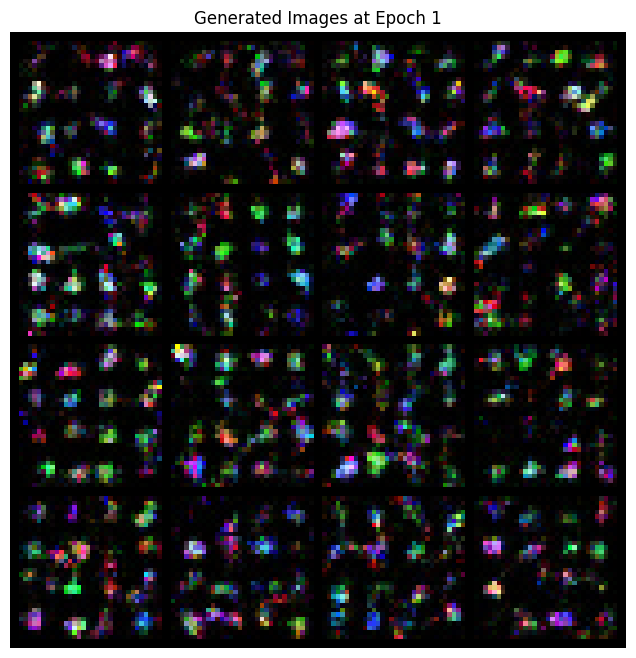

2025-07-07 11:26:04 - INFO - ------------------------------
2025-07-07 11:26:06 - INFO - Epoch: 2/60 | Batch: 0/176 | Loss (NLL): -6835.0571 | BPD: 4.7901
2025-07-07 11:27:43 - INFO - Epoch: 2/60 | Batch: 50/176 | Loss (NLL): -8037.4971 | BPD: 4.2254
2025-07-07 11:29:21 - INFO - Epoch: 2/60 | Batch: 100/176 | Loss (NLL): -8352.3916 | BPD: 4.0775
2025-07-07 11:30:58 - INFO - Epoch: 2/60 | Batch: 150/176 | Loss (NLL): -8345.8848 | BPD: 4.0805
2025-07-07 11:31:46 - INFO - --- Epoch 2 Summary ---
2025-07-07 11:31:46 - INFO - Average Loss: -7979.8377 | Time: 342.94s
2025-07-07 11:31:46 - INFO - Generating sample images...


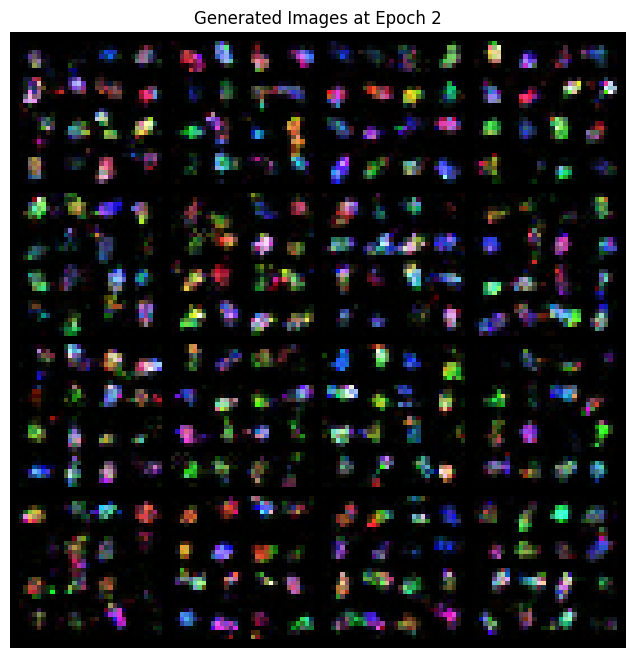

2025-07-07 11:31:47 - INFO - ------------------------------
2025-07-07 11:31:50 - INFO - Epoch: 3/60 | Batch: 0/176 | Loss (NLL): -8932.9180 | BPD: 3.8049
2025-07-07 11:33:28 - INFO - Epoch: 3/60 | Batch: 50/176 | Loss (NLL): -8854.6309 | BPD: 3.8416
2025-07-07 11:35:06 - INFO - Epoch: 3/60 | Batch: 100/176 | Loss (NLL): -9218.9043 | BPD: 3.6706
2025-07-07 11:36:43 - INFO - Epoch: 3/60 | Batch: 150/176 | Loss (NLL): -9467.7148 | BPD: 3.5537
2025-07-07 11:37:31 - INFO - --- Epoch 3 Summary ---
2025-07-07 11:37:31 - INFO - Average Loss: -9040.0444 | Time: 343.87s
2025-07-07 11:37:31 - INFO - Generating sample images...


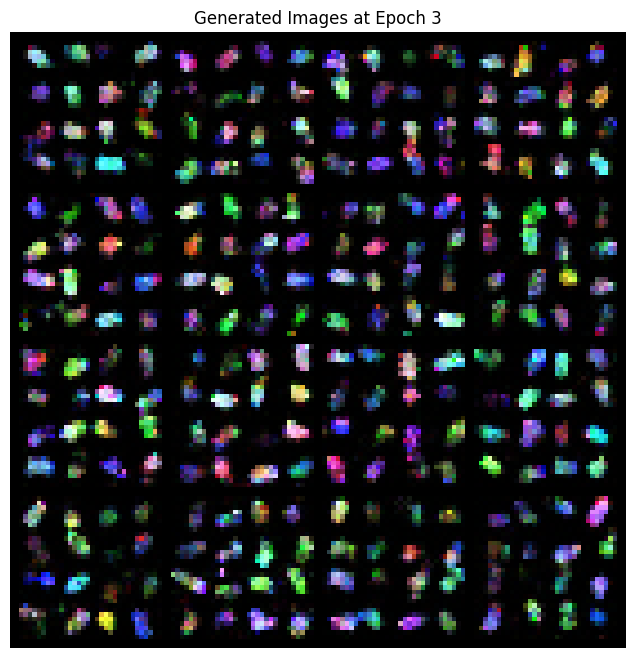

2025-07-07 11:37:31 - INFO - ------------------------------
2025-07-07 11:37:34 - INFO - Epoch: 4/60 | Batch: 0/176 | Loss (NLL): -9548.4814 | BPD: 3.5158
2025-07-07 11:39:11 - INFO - Epoch: 4/60 | Batch: 50/176 | Loss (NLL): -9525.9941 | BPD: 3.5263
2025-07-07 11:40:50 - INFO - Epoch: 4/60 | Batch: 100/176 | Loss (NLL): -9584.4004 | BPD: 3.4989
2025-07-07 11:42:28 - INFO - Epoch: 4/60 | Batch: 150/176 | Loss (NLL): -9601.7188 | BPD: 3.4908
2025-07-07 11:43:16 - INFO - --- Epoch 4 Summary ---
2025-07-07 11:43:16 - INFO - Average Loss: -9492.1616 | Time: 344.84s
2025-07-07 11:43:16 - INFO - Generating sample images...


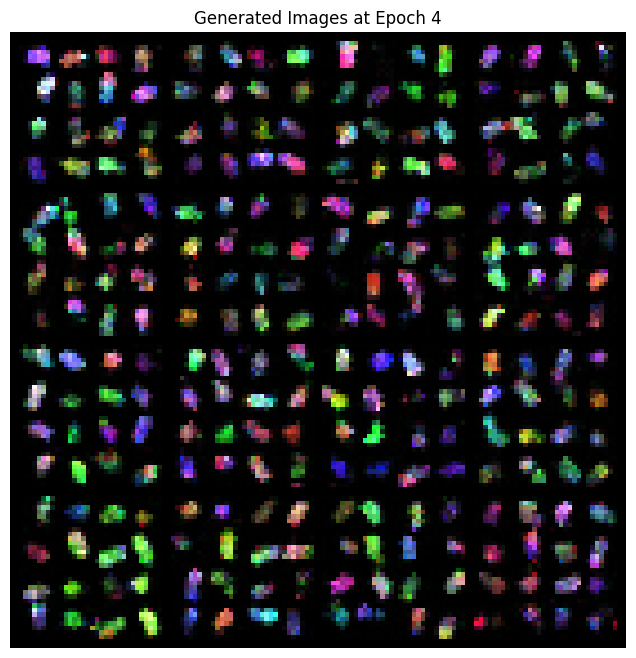

2025-07-07 11:43:17 - INFO - ------------------------------
2025-07-07 11:43:19 - INFO - Epoch: 5/60 | Batch: 0/176 | Loss (NLL): -9771.1621 | BPD: 3.4112
2025-07-07 11:44:56 - INFO - Epoch: 5/60 | Batch: 50/176 | Loss (NLL): -10110.2949 | BPD: 3.2519
2025-07-07 11:46:34 - INFO - Epoch: 5/60 | Batch: 100/176 | Loss (NLL): -9840.0342 | BPD: 3.3789
2025-07-07 11:48:10 - INFO - Epoch: 5/60 | Batch: 150/176 | Loss (NLL): -10356.6895 | BPD: 3.1362
2025-07-07 11:48:59 - INFO - --- Epoch 5 Summary ---
2025-07-07 11:48:59 - INFO - Average Loss: -9959.2422 | Time: 342.16s
2025-07-07 11:48:59 - INFO - Generating sample images...


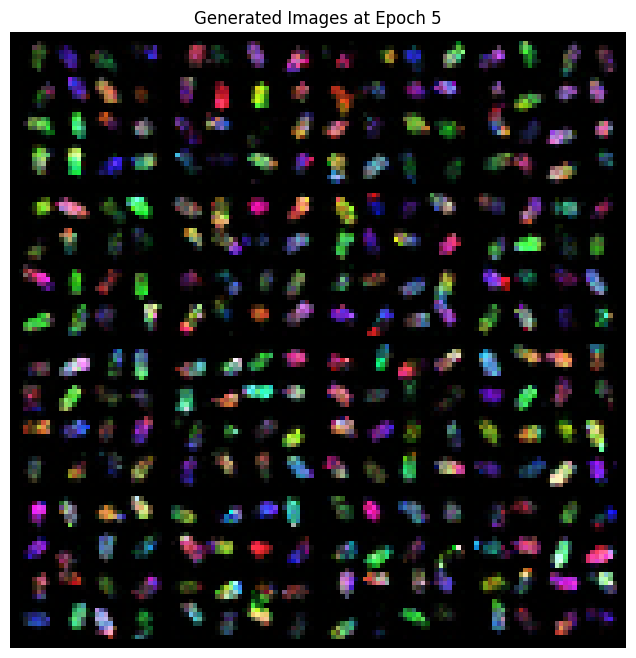

2025-07-07 11:48:59 - INFO - ------------------------------
2025-07-07 11:49:02 - INFO - Epoch: 6/60 | Batch: 0/176 | Loss (NLL): -9751.2061 | BPD: 3.4206
2025-07-07 11:50:39 - INFO - Epoch: 6/60 | Batch: 50/176 | Loss (NLL): -10428.2158 | BPD: 3.1026
2025-07-07 11:52:16 - INFO - Epoch: 6/60 | Batch: 100/176 | Loss (NLL): -10556.4238 | BPD: 3.0424
2025-07-07 11:53:52 - INFO - Epoch: 6/60 | Batch: 150/176 | Loss (NLL): -10466.9229 | BPD: 3.0844
2025-07-07 11:54:41 - INFO - --- Epoch 6 Summary ---
2025-07-07 11:54:41 - INFO - Average Loss: -10218.5870 | Time: 341.25s
2025-07-07 11:54:41 - INFO - Generating sample images...


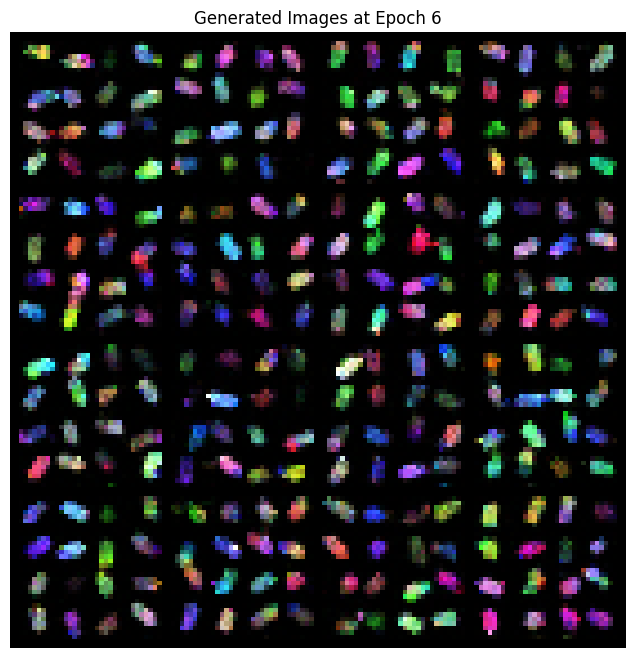

2025-07-07 11:54:41 - INFO - ------------------------------
2025-07-07 11:54:44 - INFO - Epoch: 7/60 | Batch: 0/176 | Loss (NLL): -10621.1797 | BPD: 3.0120
2025-07-07 11:56:20 - INFO - Epoch: 7/60 | Batch: 50/176 | Loss (NLL): -10225.3672 | BPD: 3.1979
2025-07-07 11:57:58 - INFO - Epoch: 7/60 | Batch: 100/176 | Loss (NLL): -10586.3418 | BPD: 3.0284
2025-07-07 11:59:35 - INFO - Epoch: 7/60 | Batch: 150/176 | Loss (NLL): -10491.1982 | BPD: 3.0730
2025-07-07 12:00:23 - INFO - --- Epoch 7 Summary ---
2025-07-07 12:00:23 - INFO - Average Loss: -10407.1624 | Time: 341.62s
2025-07-07 12:00:23 - INFO - Generating sample images...


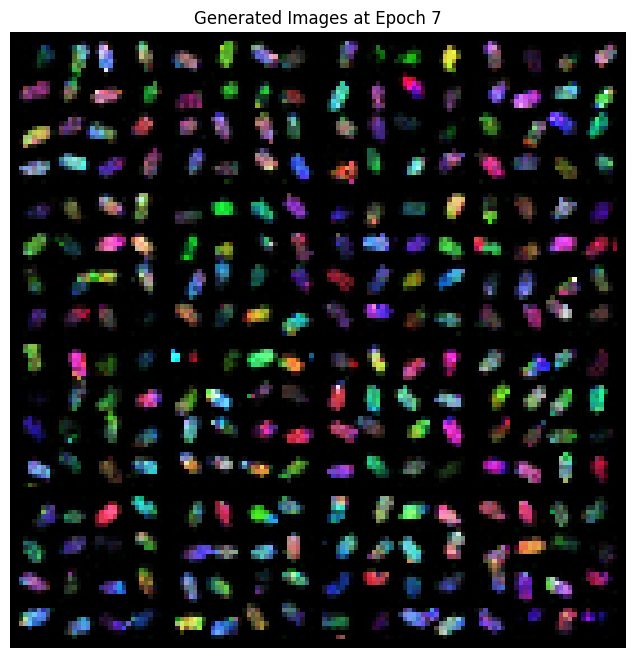

2025-07-07 12:00:23 - INFO - ------------------------------
2025-07-07 12:00:26 - INFO - Epoch: 8/60 | Batch: 0/176 | Loss (NLL): -10539.2520 | BPD: 3.0505
2025-07-07 12:02:03 - INFO - Epoch: 8/60 | Batch: 50/176 | Loss (NLL): -10571.8057 | BPD: 3.0352
2025-07-07 12:03:40 - INFO - Epoch: 8/60 | Batch: 100/176 | Loss (NLL): -10495.4570 | BPD: 3.0710
2025-07-07 12:05:16 - INFO - Epoch: 8/60 | Batch: 150/176 | Loss (NLL): -11011.2461 | BPD: 2.8288
2025-07-07 12:06:05 - INFO - --- Epoch 8 Summary ---
2025-07-07 12:06:05 - INFO - Average Loss: -10634.1593 | Time: 341.31s
2025-07-07 12:06:05 - INFO - Generating sample images...


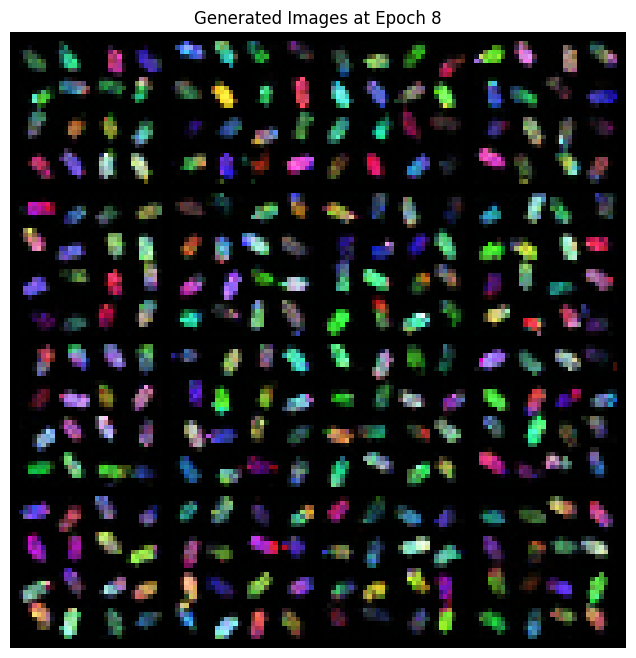

2025-07-07 12:06:05 - INFO - ------------------------------
2025-07-07 12:06:08 - INFO - Epoch: 9/60 | Batch: 0/176 | Loss (NLL): -10180.8584 | BPD: 3.2188
2025-07-07 12:07:45 - INFO - Epoch: 9/60 | Batch: 50/176 | Loss (NLL): -11044.2715 | BPD: 2.8133
2025-07-07 12:09:22 - INFO - Epoch: 9/60 | Batch: 100/176 | Loss (NLL): -10912.3018 | BPD: 2.8753
2025-07-07 12:10:59 - INFO - Epoch: 9/60 | Batch: 150/176 | Loss (NLL): -10747.2676 | BPD: 2.9528
2025-07-07 12:11:47 - INFO - --- Epoch 9 Summary ---
2025-07-07 12:11:47 - INFO - Average Loss: -10866.0249 | Time: 342.04s
2025-07-07 12:11:47 - INFO - Generating sample images...


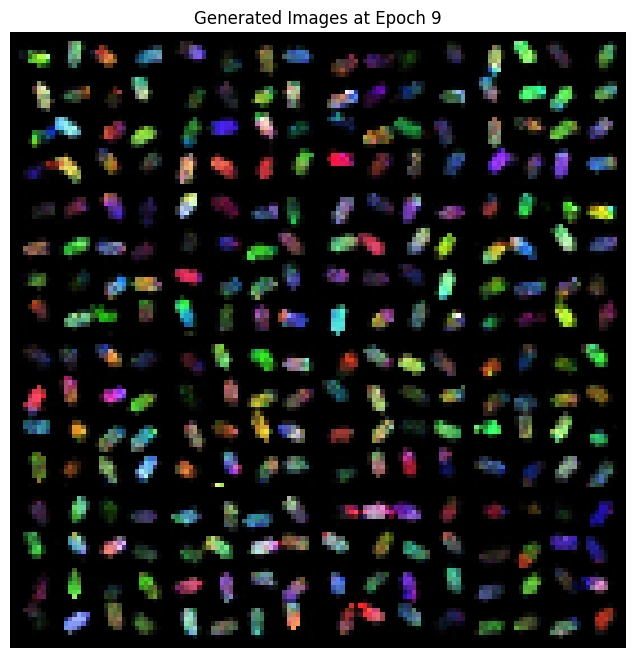

2025-07-07 12:11:47 - INFO - ------------------------------
2025-07-07 12:11:50 - INFO - Epoch: 10/60 | Batch: 0/176 | Loss (NLL): -10988.9980 | BPD: 2.8393
2025-07-07 12:13:27 - INFO - Epoch: 10/60 | Batch: 50/176 | Loss (NLL): -11067.1875 | BPD: 2.8025
2025-07-07 12:15:03 - INFO - Epoch: 10/60 | Batch: 100/176 | Loss (NLL): -11189.8730 | BPD: 2.7449
2025-07-07 12:16:40 - INFO - Epoch: 10/60 | Batch: 150/176 | Loss (NLL): -10902.4287 | BPD: 2.8799
2025-07-07 12:17:28 - INFO - --- Epoch 10 Summary ---
2025-07-07 12:17:28 - INFO - Average Loss: -10956.2347 | Time: 340.77s
2025-07-07 12:17:28 - INFO - Generating sample images...


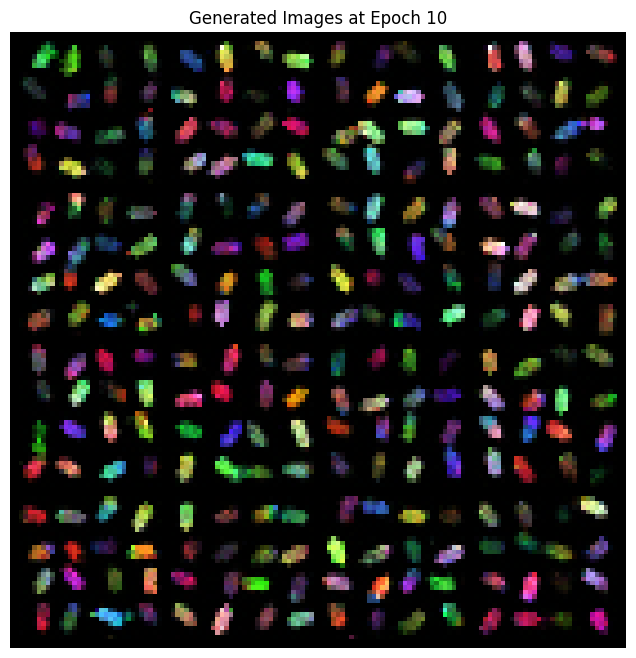

2025-07-07 12:17:29 - INFO - ------------------------------
2025-07-07 12:17:31 - INFO - Epoch: 11/60 | Batch: 0/176 | Loss (NLL): -10805.1191 | BPD: 2.9256
2025-07-07 12:19:08 - INFO - Epoch: 11/60 | Batch: 50/176 | Loss (NLL): -11144.2402 | BPD: 2.7664
2025-07-07 12:20:45 - INFO - Epoch: 11/60 | Batch: 100/176 | Loss (NLL): -11398.2793 | BPD: 2.6471
2025-07-07 12:22:22 - INFO - Epoch: 11/60 | Batch: 150/176 | Loss (NLL): -11281.6953 | BPD: 2.7018
2025-07-07 12:23:10 - INFO - --- Epoch 11 Summary ---
2025-07-07 12:23:10 - INFO - Average Loss: -11107.3708 | Time: 341.79s
2025-07-07 12:23:10 - INFO - Generating sample images...


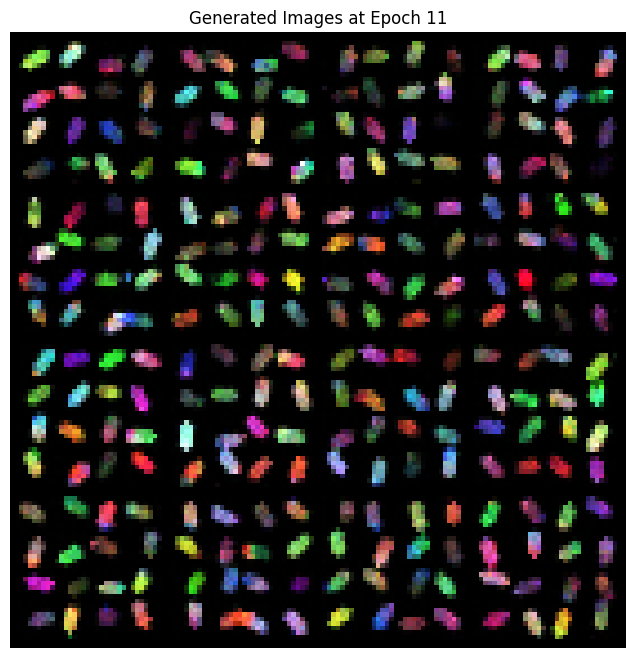

2025-07-07 12:23:11 - INFO - ------------------------------
2025-07-07 12:23:14 - INFO - Epoch: 12/60 | Batch: 0/176 | Loss (NLL): -11402.9492 | BPD: 2.6449
2025-07-07 12:24:50 - INFO - Epoch: 12/60 | Batch: 50/176 | Loss (NLL): -11112.3809 | BPD: 2.7813
2025-07-07 12:26:27 - INFO - Epoch: 12/60 | Batch: 100/176 | Loss (NLL): -11403.3574 | BPD: 2.6447
2025-07-07 12:28:05 - INFO - Epoch: 12/60 | Batch: 150/176 | Loss (NLL): -11159.1328 | BPD: 2.7594
2025-07-07 12:28:53 - INFO - --- Epoch 12 Summary ---
2025-07-07 12:28:53 - INFO - Average Loss: -11226.6127 | Time: 342.48s
2025-07-07 12:28:53 - INFO - Generating sample images...


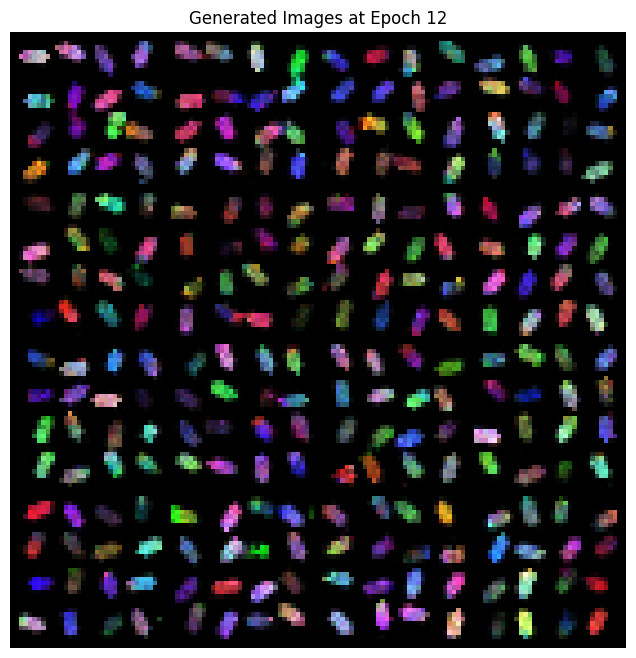

2025-07-07 12:28:54 - INFO - ------------------------------
2025-07-07 12:28:57 - INFO - Epoch: 13/60 | Batch: 0/176 | Loss (NLL): -11062.2754 | BPD: 2.8049
2025-07-07 12:30:34 - INFO - Epoch: 13/60 | Batch: 50/176 | Loss (NLL): -11351.9023 | BPD: 2.6688
2025-07-07 12:32:12 - INFO - Epoch: 13/60 | Batch: 100/176 | Loss (NLL): -11165.4775 | BPD: 2.7564
2025-07-07 12:33:49 - INFO - Epoch: 13/60 | Batch: 150/176 | Loss (NLL): -11191.3809 | BPD: 2.7442
2025-07-07 12:34:37 - INFO - --- Epoch 13 Summary ---
2025-07-07 12:34:37 - INFO - Average Loss: -11219.0859 | Time: 343.63s
2025-07-07 12:34:37 - INFO - Generating sample images...


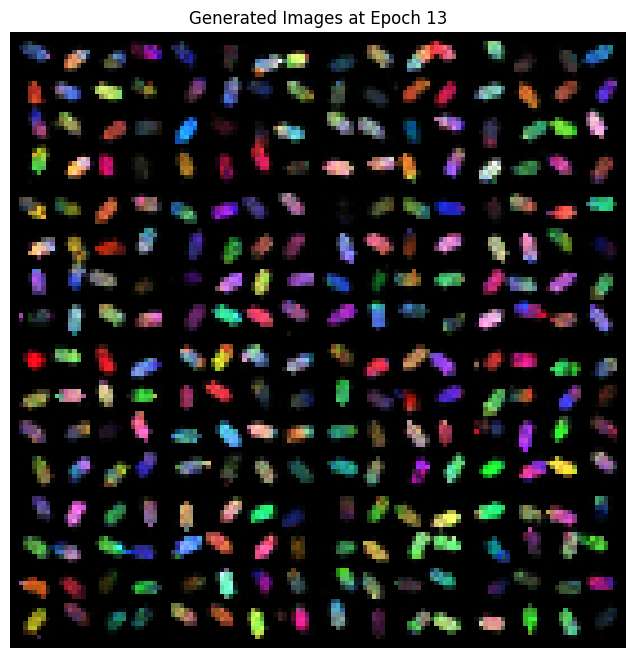

2025-07-07 12:34:38 - INFO - ------------------------------
2025-07-07 12:34:41 - INFO - Epoch: 14/60 | Batch: 0/176 | Loss (NLL): -11256.7285 | BPD: 2.7135
2025-07-07 12:36:18 - INFO - Epoch: 14/60 | Batch: 50/176 | Loss (NLL): -11622.2090 | BPD: 2.5419
2025-07-07 12:37:55 - INFO - Epoch: 14/60 | Batch: 100/176 | Loss (NLL): -11097.3906 | BPD: 2.7884
2025-07-07 12:39:32 - INFO - Epoch: 14/60 | Batch: 150/176 | Loss (NLL): -11474.3438 | BPD: 2.6113
2025-07-07 12:40:21 - INFO - --- Epoch 14 Summary ---
2025-07-07 12:40:21 - INFO - Average Loss: -11397.0241 | Time: 342.74s
2025-07-07 12:40:21 - INFO - Generating sample images...


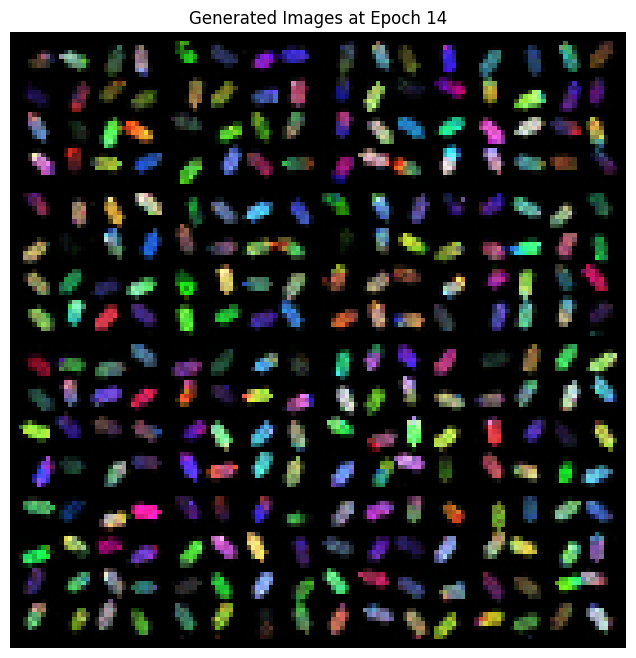

2025-07-07 12:40:21 - INFO - ------------------------------
2025-07-07 12:40:24 - INFO - Epoch: 15/60 | Batch: 0/176 | Loss (NLL): -11245.9141 | BPD: 2.7186
2025-07-07 12:42:01 - INFO - Epoch: 15/60 | Batch: 50/176 | Loss (NLL): -11565.1436 | BPD: 2.5687
2025-07-07 12:43:38 - INFO - Epoch: 15/60 | Batch: 100/176 | Loss (NLL): -11572.8926 | BPD: 2.5651
2025-07-07 12:45:15 - INFO - Epoch: 15/60 | Batch: 150/176 | Loss (NLL): -11699.2168 | BPD: 2.5057
2025-07-07 12:46:04 - INFO - --- Epoch 15 Summary ---
2025-07-07 12:46:04 - INFO - Average Loss: -11495.5946 | Time: 342.60s
2025-07-07 12:46:04 - INFO - Generating sample images...


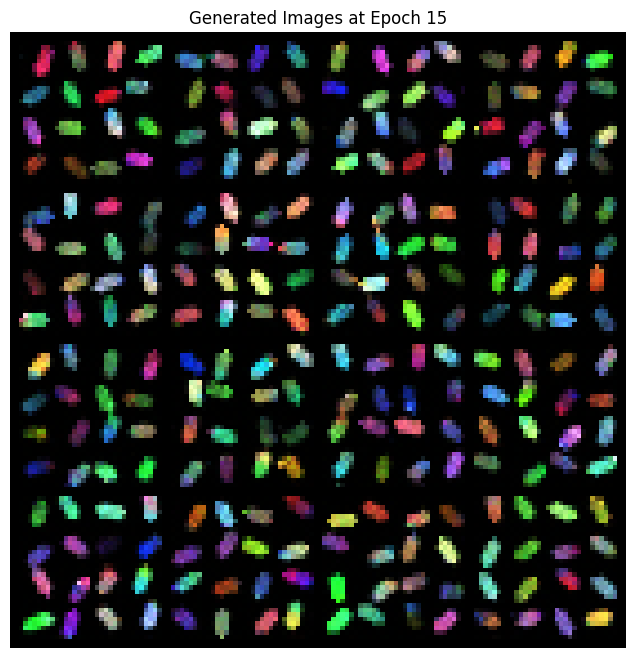

2025-07-07 12:46:04 - INFO - ------------------------------
2025-07-07 12:46:07 - INFO - Epoch: 16/60 | Batch: 0/176 | Loss (NLL): -11631.0811 | BPD: 2.5377
2025-07-07 12:47:45 - INFO - Epoch: 16/60 | Batch: 50/176 | Loss (NLL): -11537.3379 | BPD: 2.5818
2025-07-07 12:49:22 - INFO - Epoch: 16/60 | Batch: 100/176 | Loss (NLL): -10594.3545 | BPD: 3.0246
2025-07-07 12:50:59 - INFO - Epoch: 16/60 | Batch: 150/176 | Loss (NLL): -11682.8496 | BPD: 2.5134
2025-07-07 12:51:47 - INFO - --- Epoch 16 Summary ---
2025-07-07 12:51:47 - INFO - Average Loss: -11565.7781 | Time: 342.96s
2025-07-07 12:51:47 - INFO - Generating sample images...


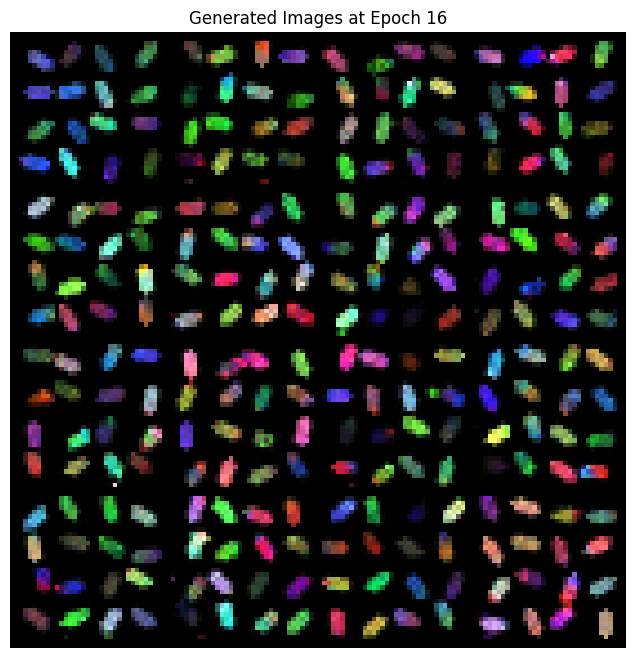

2025-07-07 12:51:48 - INFO - ------------------------------
2025-07-07 12:51:51 - INFO - Epoch: 17/60 | Batch: 0/176 | Loss (NLL): -11826.5781 | BPD: 2.4459
2025-07-07 12:53:28 - INFO - Epoch: 17/60 | Batch: 50/176 | Loss (NLL): -11708.1758 | BPD: 2.5015
2025-07-07 12:55:05 - INFO - Epoch: 17/60 | Batch: 100/176 | Loss (NLL): -11675.9824 | BPD: 2.5166
2025-07-07 12:56:42 - INFO - Epoch: 17/60 | Batch: 150/176 | Loss (NLL): -11805.5547 | BPD: 2.4558
2025-07-07 12:57:30 - INFO - --- Epoch 17 Summary ---
2025-07-07 12:57:30 - INFO - Average Loss: -11687.8165 | Time: 342.42s
2025-07-07 12:57:30 - INFO - Generating sample images...


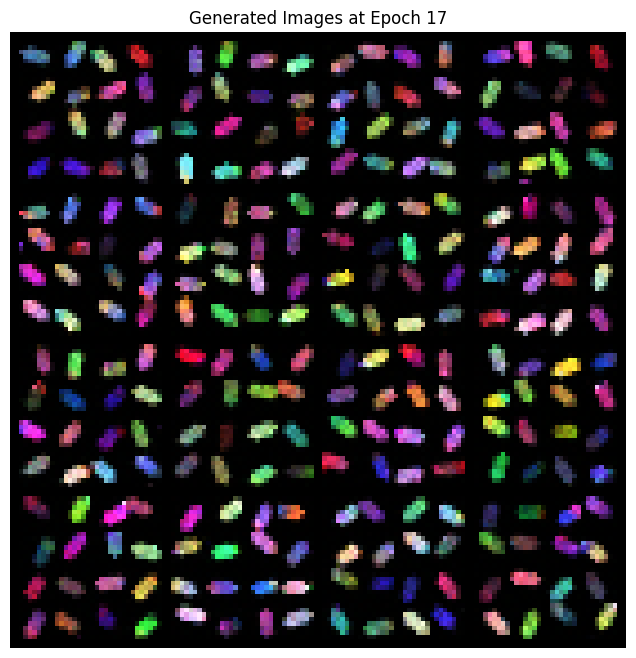

2025-07-07 12:57:31 - INFO - ------------------------------
2025-07-07 12:57:34 - INFO - Epoch: 18/60 | Batch: 0/176 | Loss (NLL): -11420.0781 | BPD: 2.6368
2025-07-07 12:59:11 - INFO - Epoch: 18/60 | Batch: 50/176 | Loss (NLL): -11757.1641 | BPD: 2.4785
2025-07-07 13:00:48 - INFO - Epoch: 18/60 | Batch: 100/176 | Loss (NLL): -11766.2393 | BPD: 2.4743
2025-07-07 13:02:25 - INFO - Epoch: 18/60 | Batch: 150/176 | Loss (NLL): -12228.2129 | BPD: 2.2573
2025-07-07 13:03:13 - INFO - --- Epoch 18 Summary ---
2025-07-07 13:03:13 - INFO - Average Loss: -11697.0881 | Time: 341.97s
2025-07-07 13:03:13 - INFO - Generating sample images...


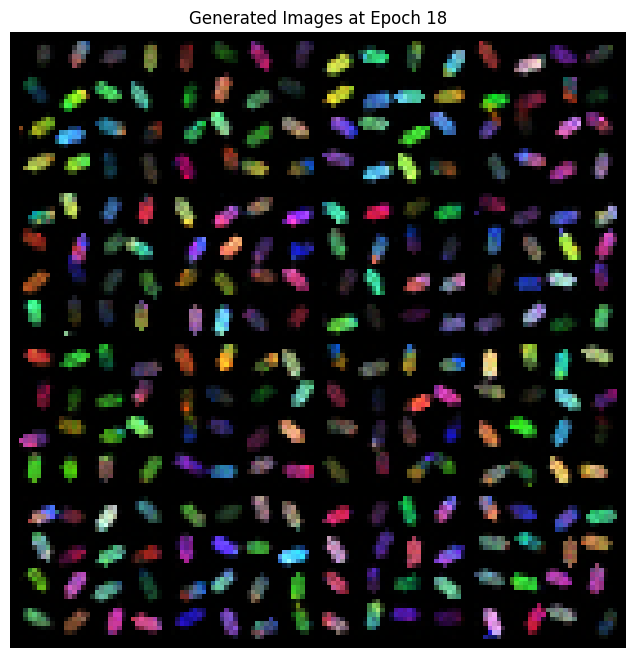

2025-07-07 13:03:13 - INFO - ------------------------------
2025-07-07 13:03:16 - INFO - Epoch: 19/60 | Batch: 0/176 | Loss (NLL): -11878.4082 | BPD: 2.4216
2025-07-07 13:04:53 - INFO - Epoch: 19/60 | Batch: 50/176 | Loss (NLL): -12131.3564 | BPD: 2.3028
2025-07-07 13:06:31 - INFO - Epoch: 19/60 | Batch: 100/176 | Loss (NLL): -11942.1572 | BPD: 2.3916
2025-07-07 13:08:08 - INFO - Epoch: 19/60 | Batch: 150/176 | Loss (NLL): -11826.7441 | BPD: 2.4458
2025-07-07 13:08:57 - INFO - --- Epoch 19 Summary ---
2025-07-07 13:08:57 - INFO - Average Loss: -11812.6153 | Time: 343.28s
2025-07-07 13:08:57 - INFO - Generating sample images...


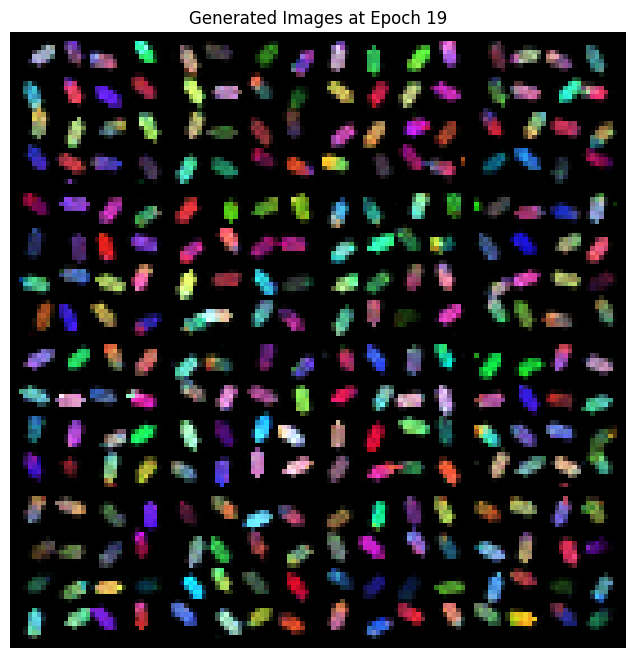

2025-07-07 13:08:57 - INFO - ------------------------------
2025-07-07 13:09:00 - INFO - Epoch: 20/60 | Batch: 0/176 | Loss (NLL): -11854.3271 | BPD: 2.4329
2025-07-07 13:10:37 - INFO - Epoch: 20/60 | Batch: 50/176 | Loss (NLL): -11638.9297 | BPD: 2.5340
2025-07-07 13:12:14 - INFO - Epoch: 20/60 | Batch: 100/176 | Loss (NLL): -11684.4551 | BPD: 2.5127
2025-07-07 13:13:50 - INFO - Epoch: 20/60 | Batch: 150/176 | Loss (NLL): -11763.1914 | BPD: 2.4757
2025-07-07 13:14:38 - INFO - --- Epoch 20 Summary ---
2025-07-07 13:14:38 - INFO - Average Loss: -11827.1164 | Time: 341.51s
2025-07-07 13:14:38 - INFO - Generating sample images...


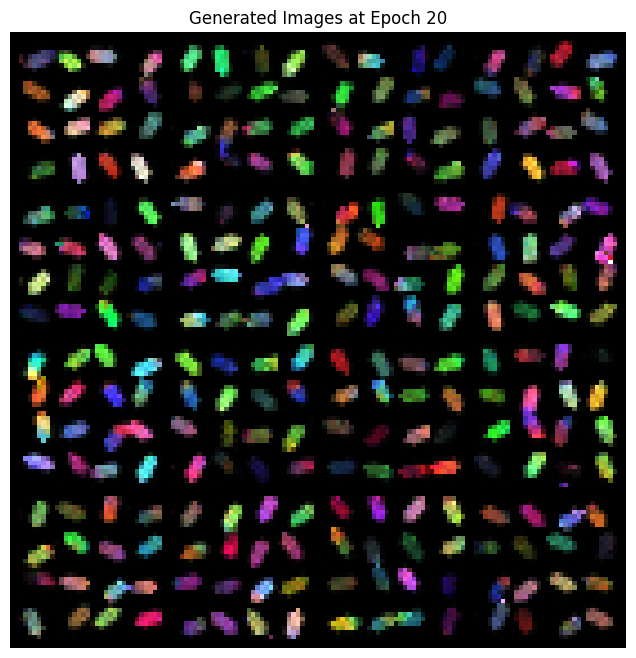

2025-07-07 13:14:39 - INFO - ------------------------------
2025-07-07 13:14:42 - INFO - Epoch: 21/60 | Batch: 0/176 | Loss (NLL): -11455.4229 | BPD: 2.6202
2025-07-07 13:16:19 - INFO - Epoch: 21/60 | Batch: 50/176 | Loss (NLL): -11740.7598 | BPD: 2.4862
2025-07-07 13:17:56 - INFO - Epoch: 21/60 | Batch: 100/176 | Loss (NLL): -12105.2500 | BPD: 2.3150
2025-07-07 13:19:33 - INFO - Epoch: 21/60 | Batch: 150/176 | Loss (NLL): -11677.9297 | BPD: 2.5157
2025-07-07 13:20:21 - INFO - --- Epoch 21 Summary ---
2025-07-07 13:20:21 - INFO - Average Loss: -11873.5950 | Time: 342.09s
2025-07-07 13:20:21 - INFO - Generating sample images...


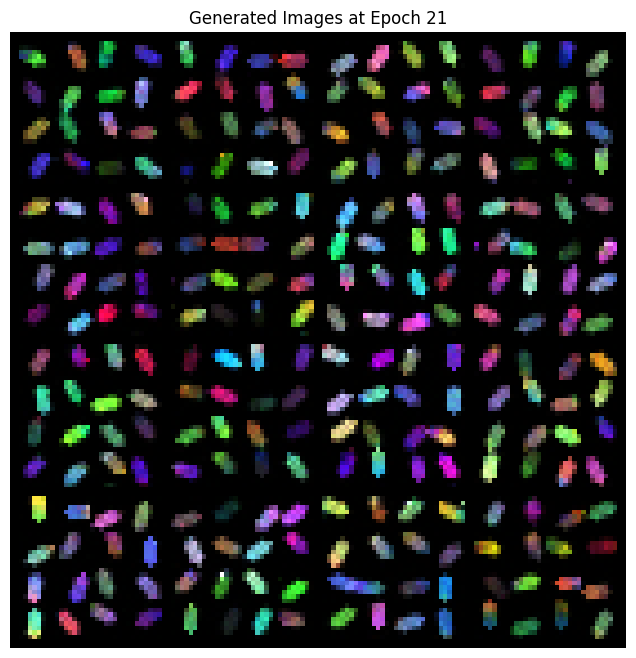

2025-07-07 13:20:22 - INFO - ------------------------------
2025-07-07 13:20:24 - INFO - Epoch: 22/60 | Batch: 0/176 | Loss (NLL): -12088.7910 | BPD: 2.3228
2025-07-07 13:22:02 - INFO - Epoch: 22/60 | Batch: 50/176 | Loss (NLL): -11977.2559 | BPD: 2.3752
2025-07-07 13:23:39 - INFO - Epoch: 22/60 | Batch: 100/176 | Loss (NLL): -12037.4297 | BPD: 2.3469
2025-07-07 13:25:16 - INFO - Epoch: 22/60 | Batch: 150/176 | Loss (NLL): -12109.2979 | BPD: 2.3131
2025-07-07 13:26:04 - INFO - --- Epoch 22 Summary ---
2025-07-07 13:26:04 - INFO - Average Loss: -12021.4887 | Time: 342.72s
2025-07-07 13:26:04 - INFO - Generating sample images...


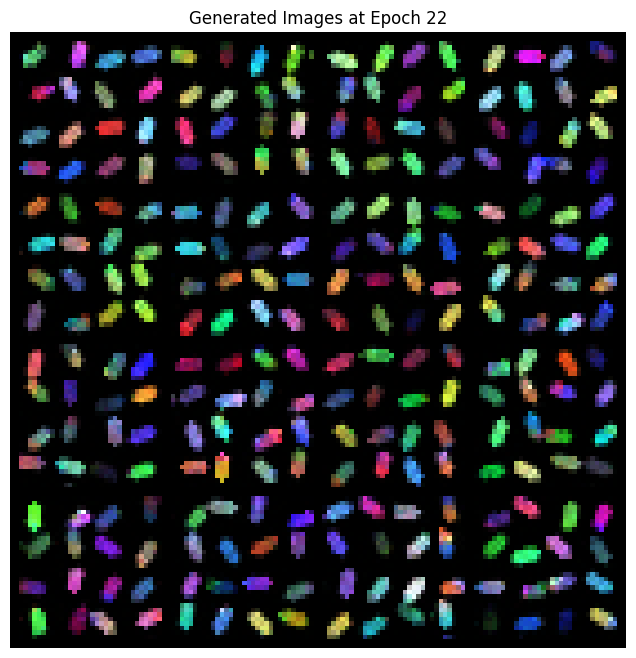

2025-07-07 13:26:05 - INFO - ------------------------------
2025-07-07 13:26:08 - INFO - Epoch: 23/60 | Batch: 0/176 | Loss (NLL): -12080.9521 | BPD: 2.3265
2025-07-07 13:27:45 - INFO - Epoch: 23/60 | Batch: 50/176 | Loss (NLL): -12170.5156 | BPD: 2.2844
2025-07-07 13:29:22 - INFO - Epoch: 23/60 | Batch: 100/176 | Loss (NLL): -12120.8359 | BPD: 2.3077
2025-07-07 13:30:59 - INFO - Epoch: 23/60 | Batch: 150/176 | Loss (NLL): -11864.9746 | BPD: 2.4279
2025-07-07 13:31:48 - INFO - --- Epoch 23 Summary ---
2025-07-07 13:31:48 - INFO - Average Loss: -12087.9728 | Time: 342.80s
2025-07-07 13:31:48 - INFO - Generating sample images...


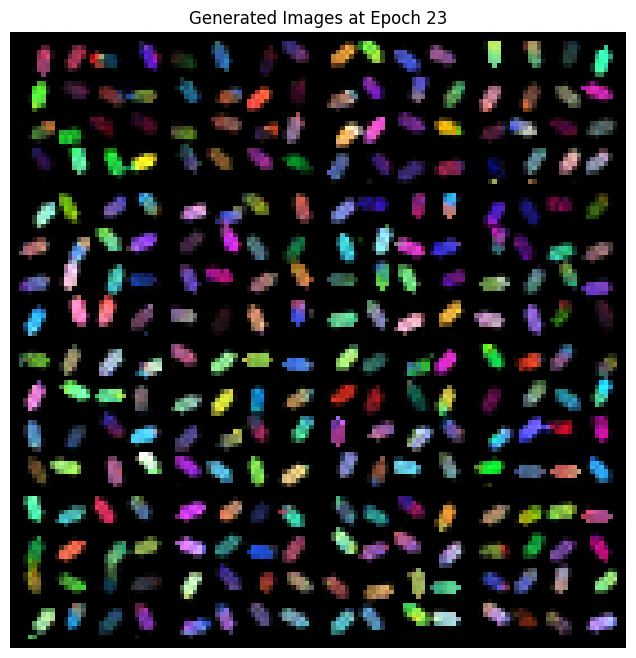

2025-07-07 13:31:48 - INFO - ------------------------------
2025-07-07 13:31:51 - INFO - Epoch: 24/60 | Batch: 0/176 | Loss (NLL): -12330.7930 | BPD: 2.2091
2025-07-07 13:33:28 - INFO - Epoch: 24/60 | Batch: 50/176 | Loss (NLL): -11836.7939 | BPD: 2.4411
2025-07-07 13:35:05 - INFO - Epoch: 24/60 | Batch: 100/176 | Loss (NLL): -12228.2988 | BPD: 2.2573
2025-07-07 13:36:43 - INFO - Epoch: 24/60 | Batch: 150/176 | Loss (NLL): -12158.3984 | BPD: 2.2901
2025-07-07 13:37:32 - INFO - --- Epoch 24 Summary ---
2025-07-07 13:37:32 - INFO - Average Loss: -12092.5270 | Time: 343.46s
2025-07-07 13:37:32 - INFO - Generating sample images...


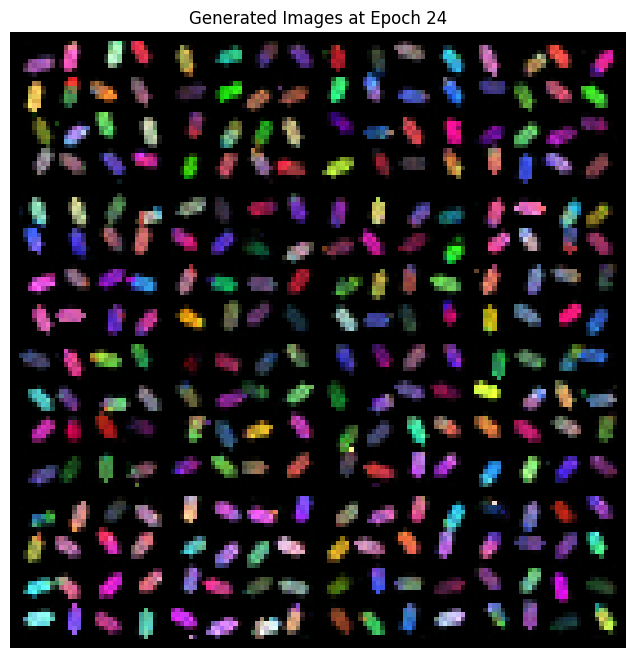

2025-07-07 13:37:32 - INFO - ------------------------------
2025-07-07 13:37:35 - INFO - Epoch: 25/60 | Batch: 0/176 | Loss (NLL): -12237.3008 | BPD: 2.2530
2025-07-07 13:39:12 - INFO - Epoch: 25/60 | Batch: 50/176 | Loss (NLL): -12233.8555 | BPD: 2.2546
2025-07-07 13:40:49 - INFO - Epoch: 25/60 | Batch: 100/176 | Loss (NLL): -12138.9736 | BPD: 2.2992
2025-07-07 13:42:26 - INFO - Epoch: 25/60 | Batch: 150/176 | Loss (NLL): -12195.6631 | BPD: 2.2726
2025-07-07 13:43:14 - INFO - --- Epoch 25 Summary ---
2025-07-07 13:43:14 - INFO - Average Loss: -12127.4888 | Time: 342.43s
2025-07-07 13:43:14 - INFO - Generating sample images...


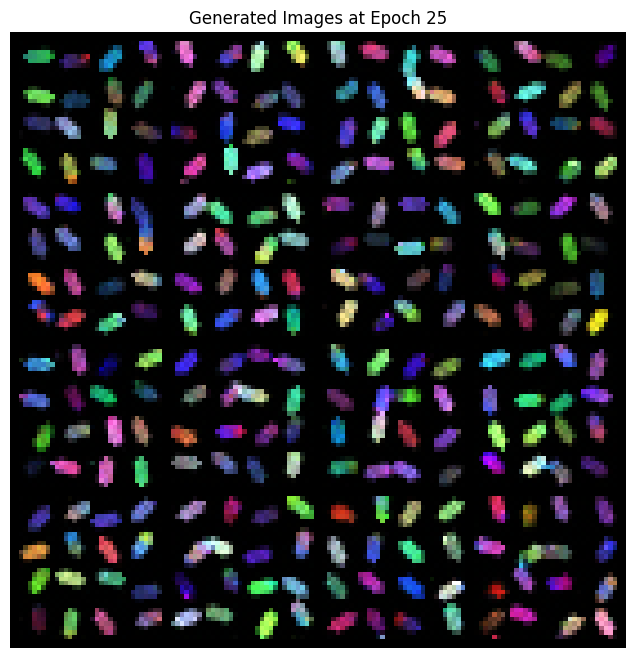

2025-07-07 13:43:15 - INFO - ------------------------------
2025-07-07 13:43:18 - INFO - Epoch: 26/60 | Batch: 0/176 | Loss (NLL): -11865.9697 | BPD: 2.4274
2025-07-07 13:44:56 - INFO - Epoch: 26/60 | Batch: 50/176 | Loss (NLL): -12115.7637 | BPD: 2.3101
2025-07-07 13:46:33 - INFO - Epoch: 26/60 | Batch: 100/176 | Loss (NLL): -11996.3613 | BPD: 2.3662
2025-07-07 13:48:10 - INFO - Epoch: 26/60 | Batch: 150/176 | Loss (NLL): -12307.5713 | BPD: 2.2200
2025-07-07 13:48:58 - INFO - --- Epoch 26 Summary ---
2025-07-07 13:48:58 - INFO - Average Loss: -12218.0036 | Time: 343.48s
2025-07-07 13:48:58 - INFO - Generating sample images...


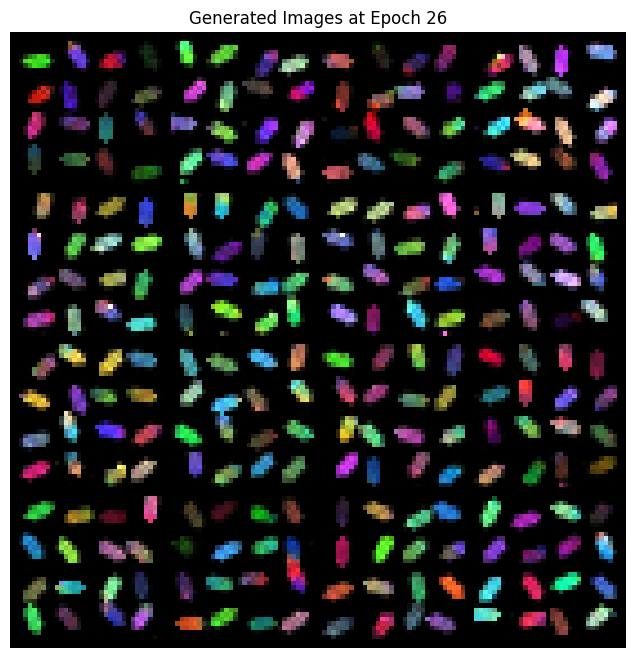

2025-07-07 13:48:59 - INFO - ------------------------------
2025-07-07 13:49:02 - INFO - Epoch: 27/60 | Batch: 0/176 | Loss (NLL): -12299.7393 | BPD: 2.2237
2025-07-07 13:50:39 - INFO - Epoch: 27/60 | Batch: 50/176 | Loss (NLL): -12246.9131 | BPD: 2.2485
2025-07-07 13:52:17 - INFO - Epoch: 27/60 | Batch: 100/176 | Loss (NLL): -12092.6621 | BPD: 2.3210
2025-07-07 13:53:54 - INFO - Epoch: 27/60 | Batch: 150/176 | Loss (NLL): -12334.8652 | BPD: 2.2072
2025-07-07 13:54:42 - INFO - --- Epoch 27 Summary ---
2025-07-07 13:54:42 - INFO - Average Loss: -12253.6433 | Time: 343.20s
2025-07-07 13:54:42 - INFO - Generating sample images...


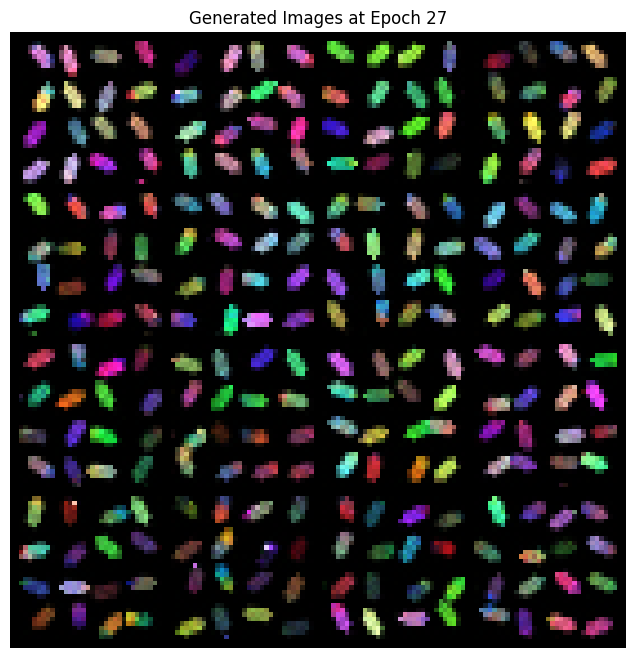

2025-07-07 13:54:42 - INFO - ------------------------------
2025-07-07 13:54:45 - INFO - Epoch: 28/60 | Batch: 0/176 | Loss (NLL): -12153.9668 | BPD: 2.2922
2025-07-07 13:56:23 - INFO - Epoch: 28/60 | Batch: 50/176 | Loss (NLL): -12263.6387 | BPD: 2.2407
2025-07-07 13:58:01 - INFO - Epoch: 28/60 | Batch: 100/176 | Loss (NLL): -12264.6797 | BPD: 2.2402
2025-07-07 13:59:38 - INFO - Epoch: 28/60 | Batch: 150/176 | Loss (NLL): -12196.3711 | BPD: 2.2723
2025-07-07 14:00:27 - INFO - --- Epoch 28 Summary ---
2025-07-07 14:00:27 - INFO - Average Loss: -12286.6735 | Time: 344.14s
2025-07-07 14:00:27 - INFO - Generating sample images...


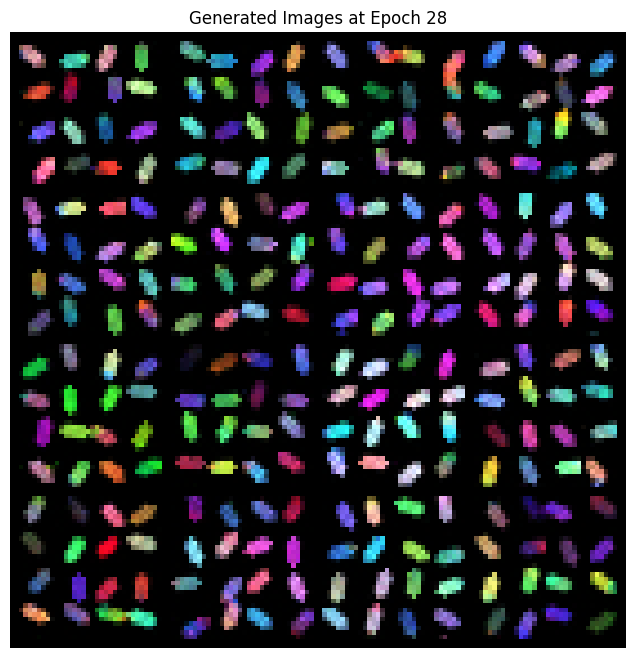

2025-07-07 14:00:27 - INFO - ------------------------------
2025-07-07 14:00:30 - INFO - Epoch: 29/60 | Batch: 0/176 | Loss (NLL): -12308.4082 | BPD: 2.2196
2025-07-07 14:02:07 - INFO - Epoch: 29/60 | Batch: 50/176 | Loss (NLL): -12622.1221 | BPD: 2.0723
2025-07-07 14:03:45 - INFO - Epoch: 29/60 | Batch: 100/176 | Loss (NLL): -12383.4619 | BPD: 2.1844
2025-07-07 14:05:22 - INFO - Epoch: 29/60 | Batch: 150/176 | Loss (NLL): -12340.7090 | BPD: 2.2045
2025-07-07 14:06:11 - INFO - --- Epoch 29 Summary ---
2025-07-07 14:06:11 - INFO - Average Loss: -12303.7388 | Time: 343.52s
2025-07-07 14:06:11 - INFO - Generating sample images...


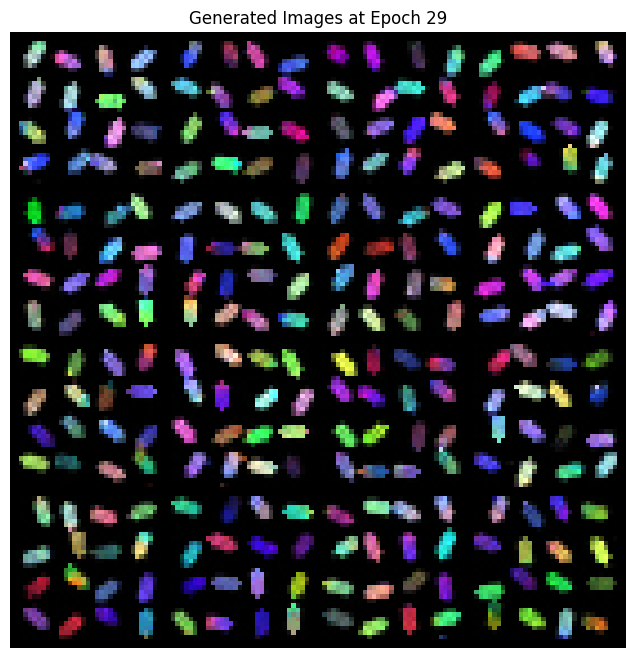

2025-07-07 14:06:11 - INFO - ------------------------------
2025-07-07 14:06:14 - INFO - Epoch: 30/60 | Batch: 0/176 | Loss (NLL): -12109.9629 | BPD: 2.3128
2025-07-07 14:07:50 - INFO - Epoch: 30/60 | Batch: 50/176 | Loss (NLL): -12051.3945 | BPD: 2.3403
2025-07-07 14:09:28 - INFO - Epoch: 30/60 | Batch: 100/176 | Loss (NLL): -12544.7627 | BPD: 2.1086
2025-07-07 14:11:04 - INFO - Epoch: 30/60 | Batch: 150/176 | Loss (NLL): -12375.9062 | BPD: 2.1879
2025-07-07 14:11:53 - INFO - --- Epoch 30 Summary ---
2025-07-07 14:11:53 - INFO - Average Loss: -12405.0836 | Time: 341.87s
2025-07-07 14:11:53 - INFO - Generating sample images...


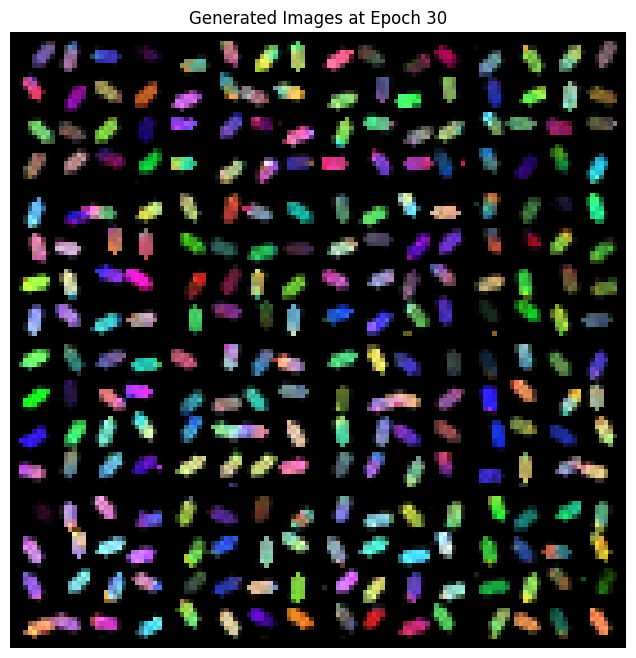

2025-07-07 14:11:53 - INFO - ------------------------------
2025-07-07 14:11:56 - INFO - Epoch: 31/60 | Batch: 0/176 | Loss (NLL): -12283.3770 | BPD: 2.2314
2025-07-07 14:13:33 - INFO - Epoch: 31/60 | Batch: 50/176 | Loss (NLL): -12668.0586 | BPD: 2.0507
2025-07-07 14:15:11 - INFO - Epoch: 31/60 | Batch: 100/176 | Loss (NLL): -12427.8359 | BPD: 2.1635
2025-07-07 14:16:48 - INFO - Epoch: 31/60 | Batch: 150/176 | Loss (NLL): -12591.5957 | BPD: 2.0866
2025-07-07 14:17:37 - INFO - --- Epoch 31 Summary ---
2025-07-07 14:17:37 - INFO - Average Loss: -12427.7966 | Time: 343.48s
2025-07-07 14:17:37 - INFO - Generating sample images...


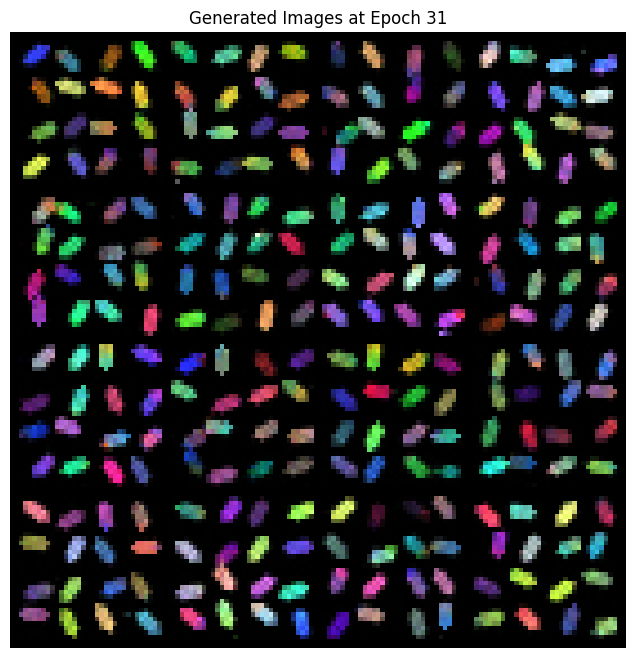

2025-07-07 14:17:37 - INFO - ------------------------------
2025-07-07 14:17:40 - INFO - Epoch: 32/60 | Batch: 0/176 | Loss (NLL): -12462.0449 | BPD: 2.1475
2025-07-07 14:19:17 - INFO - Epoch: 32/60 | Batch: 50/176 | Loss (NLL): -12481.4932 | BPD: 2.1384
2025-07-07 14:20:55 - INFO - Epoch: 32/60 | Batch: 100/176 | Loss (NLL): -12438.4414 | BPD: 2.1586
2025-07-07 14:22:32 - INFO - Epoch: 32/60 | Batch: 150/176 | Loss (NLL): -12423.1260 | BPD: 2.1658
2025-07-07 14:23:22 - INFO - --- Epoch 32 Summary ---
2025-07-07 14:23:22 - INFO - Average Loss: -12443.2014 | Time: 344.57s
2025-07-07 14:23:22 - INFO - Generating sample images...


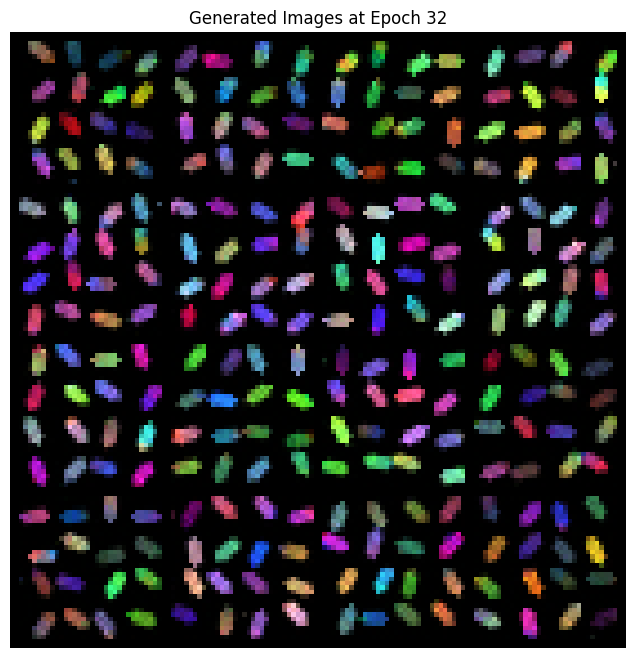

2025-07-07 14:23:22 - INFO - ------------------------------
2025-07-07 14:23:25 - INFO - Epoch: 33/60 | Batch: 0/176 | Loss (NLL): -12654.2461 | BPD: 2.0572
2025-07-07 14:25:03 - INFO - Epoch: 33/60 | Batch: 50/176 | Loss (NLL): -12775.4326 | BPD: 2.0003
2025-07-07 14:26:41 - INFO - Epoch: 33/60 | Batch: 100/176 | Loss (NLL): -12585.9355 | BPD: 2.0893
2025-07-07 14:28:18 - INFO - Epoch: 33/60 | Batch: 150/176 | Loss (NLL): -12079.4238 | BPD: 2.3272
2025-07-07 14:29:07 - INFO - --- Epoch 33 Summary ---
2025-07-07 14:29:07 - INFO - Average Loss: -12502.7324 | Time: 344.75s
2025-07-07 14:29:07 - INFO - Generating sample images...


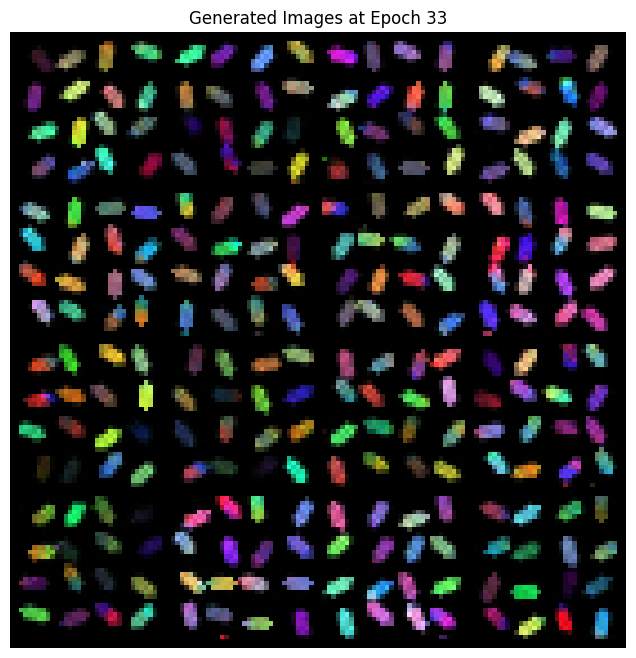

2025-07-07 14:29:07 - INFO - ------------------------------
2025-07-07 14:29:10 - INFO - Epoch: 34/60 | Batch: 0/176 | Loss (NLL): -12480.9229 | BPD: 2.1386
2025-07-07 14:30:47 - INFO - Epoch: 34/60 | Batch: 50/176 | Loss (NLL): -12497.6016 | BPD: 2.1308
2025-07-07 14:32:26 - INFO - Epoch: 34/60 | Batch: 100/176 | Loss (NLL): -12670.0518 | BPD: 2.0498
2025-07-07 14:34:03 - INFO - Epoch: 34/60 | Batch: 150/176 | Loss (NLL): -12903.2607 | BPD: 1.9403
2025-07-07 14:34:52 - INFO - --- Epoch 34 Summary ---
2025-07-07 14:34:52 - INFO - Average Loss: -12596.5399 | Time: 344.45s
2025-07-07 14:34:52 - INFO - Generating sample images...


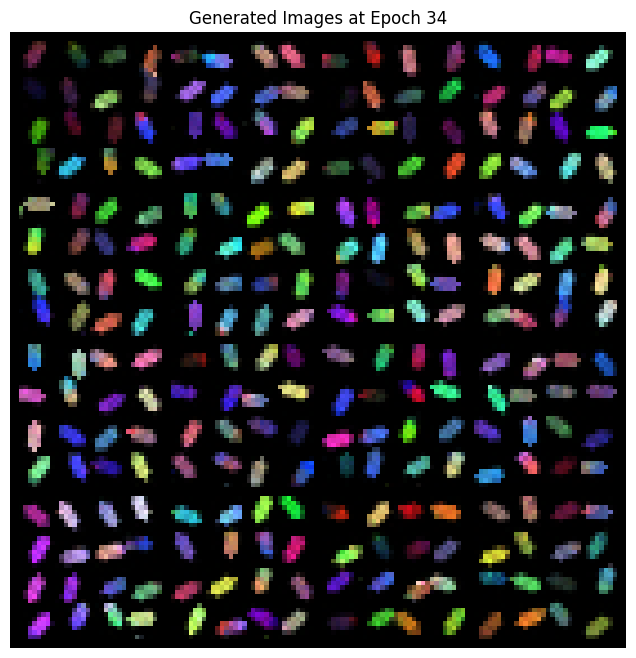

2025-07-07 14:34:52 - INFO - ------------------------------
2025-07-07 14:34:55 - INFO - Epoch: 35/60 | Batch: 0/176 | Loss (NLL): -12336.0703 | BPD: 2.2066
2025-07-07 14:36:32 - INFO - Epoch: 35/60 | Batch: 50/176 | Loss (NLL): -12544.1582 | BPD: 2.1089
2025-07-07 14:38:10 - INFO - Epoch: 35/60 | Batch: 100/176 | Loss (NLL): -12722.3555 | BPD: 2.0252
2025-07-07 14:39:47 - INFO - Epoch: 35/60 | Batch: 150/176 | Loss (NLL): -12762.3467 | BPD: 2.0065
2025-07-07 14:40:36 - INFO - --- Epoch 35 Summary ---
2025-07-07 14:40:36 - INFO - Average Loss: -12529.0003 | Time: 344.17s
2025-07-07 14:40:36 - INFO - Generating sample images...


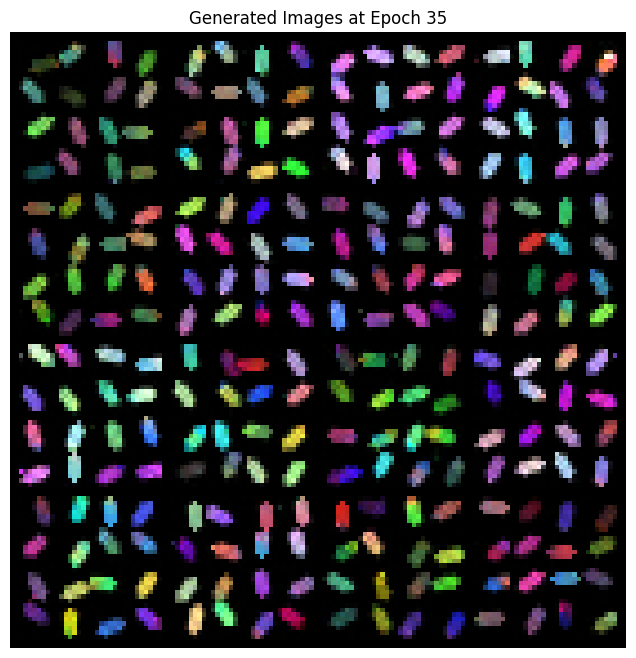

2025-07-07 14:40:37 - INFO - ------------------------------
2025-07-07 14:40:40 - INFO - Epoch: 36/60 | Batch: 0/176 | Loss (NLL): -12519.5078 | BPD: 2.1205
2025-07-07 14:42:19 - INFO - Epoch: 36/60 | Batch: 50/176 | Loss (NLL): -12369.7041 | BPD: 2.1908
2025-07-07 14:43:56 - INFO - Epoch: 36/60 | Batch: 100/176 | Loss (NLL): -12282.9336 | BPD: 2.2316
2025-07-07 14:45:33 - INFO - Epoch: 36/60 | Batch: 150/176 | Loss (NLL): -12540.3008 | BPD: 2.1107
2025-07-07 14:46:21 - INFO - --- Epoch 36 Summary ---
2025-07-07 14:46:21 - INFO - Average Loss: -12611.6939 | Time: 344.08s
2025-07-07 14:46:21 - INFO - Generating sample images...


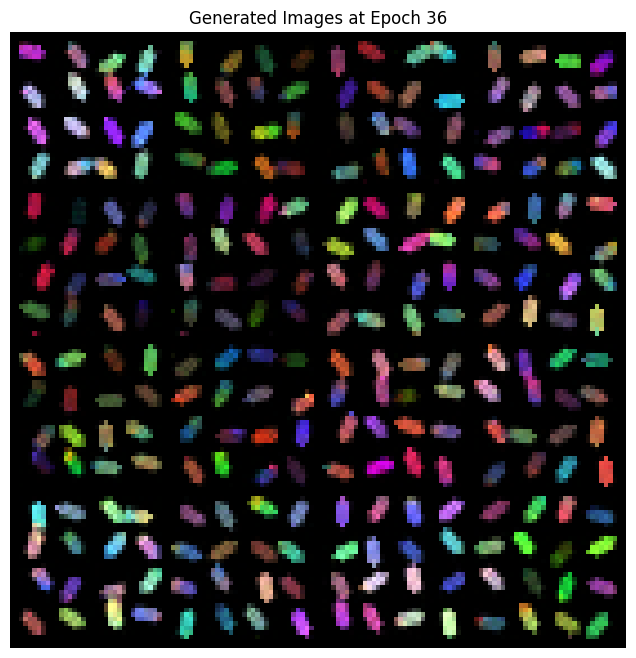

2025-07-07 14:46:21 - INFO - ------------------------------
2025-07-07 14:46:24 - INFO - Epoch: 37/60 | Batch: 0/176 | Loss (NLL): -12799.4668 | BPD: 1.9890
2025-07-07 14:48:01 - INFO - Epoch: 37/60 | Batch: 50/176 | Loss (NLL): -12448.0957 | BPD: 2.1540
2025-07-07 14:49:39 - INFO - Epoch: 37/60 | Batch: 100/176 | Loss (NLL): -12555.2227 | BPD: 2.1037
2025-07-07 14:51:16 - INFO - Epoch: 37/60 | Batch: 150/176 | Loss (NLL): -12453.5195 | BPD: 2.1515
2025-07-07 14:52:04 - INFO - --- Epoch 37 Summary ---
2025-07-07 14:52:04 - INFO - Average Loss: -12669.8013 | Time: 342.66s
2025-07-07 14:52:04 - INFO - Generating sample images...


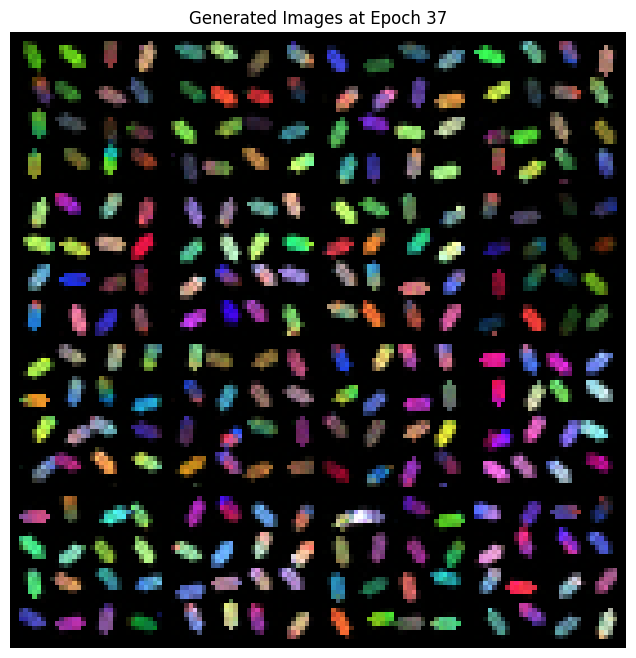

2025-07-07 14:52:04 - INFO - ------------------------------
2025-07-07 14:52:07 - INFO - Epoch: 38/60 | Batch: 0/176 | Loss (NLL): -12464.9033 | BPD: 2.1461
2025-07-07 14:53:45 - INFO - Epoch: 38/60 | Batch: 50/176 | Loss (NLL): -12772.0469 | BPD: 2.0019
2025-07-07 14:55:22 - INFO - Epoch: 38/60 | Batch: 100/176 | Loss (NLL): -12866.1230 | BPD: 1.9577
2025-07-07 14:56:59 - INFO - Epoch: 38/60 | Batch: 150/176 | Loss (NLL): -12798.0410 | BPD: 1.9897
2025-07-07 14:57:47 - INFO - --- Epoch 38 Summary ---
2025-07-07 14:57:47 - INFO - Average Loss: -12726.2556 | Time: 342.96s
2025-07-07 14:57:47 - INFO - Generating sample images...


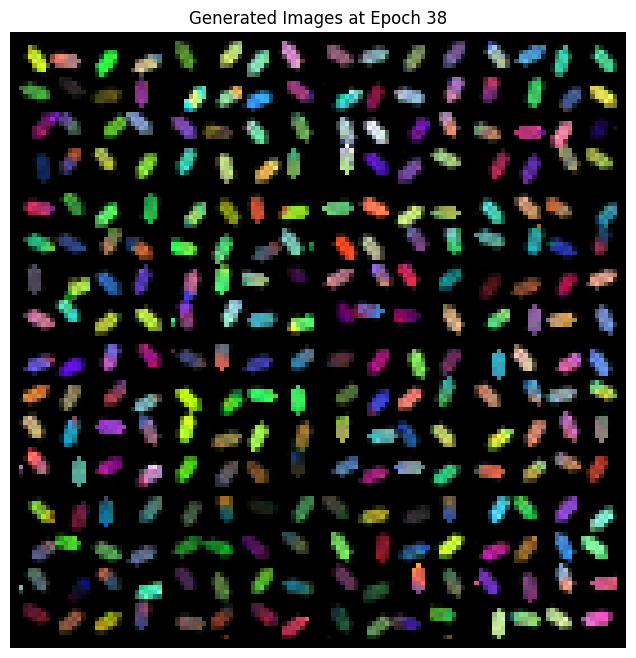

2025-07-07 14:57:48 - INFO - ------------------------------
2025-07-07 14:57:51 - INFO - Epoch: 39/60 | Batch: 0/176 | Loss (NLL): -12458.5654 | BPD: 2.1491
2025-07-07 14:59:28 - INFO - Epoch: 39/60 | Batch: 50/176 | Loss (NLL): -12882.3057 | BPD: 1.9501
2025-07-07 15:01:07 - INFO - Epoch: 39/60 | Batch: 100/176 | Loss (NLL): -12828.1289 | BPD: 1.9756
2025-07-07 15:02:44 - INFO - Epoch: 39/60 | Batch: 150/176 | Loss (NLL): -12724.3184 | BPD: 2.0243
2025-07-07 15:03:33 - INFO - --- Epoch 39 Summary ---
2025-07-07 15:03:33 - INFO - Average Loss: -12756.7297 | Time: 344.76s
2025-07-07 15:03:33 - INFO - Generating sample images...


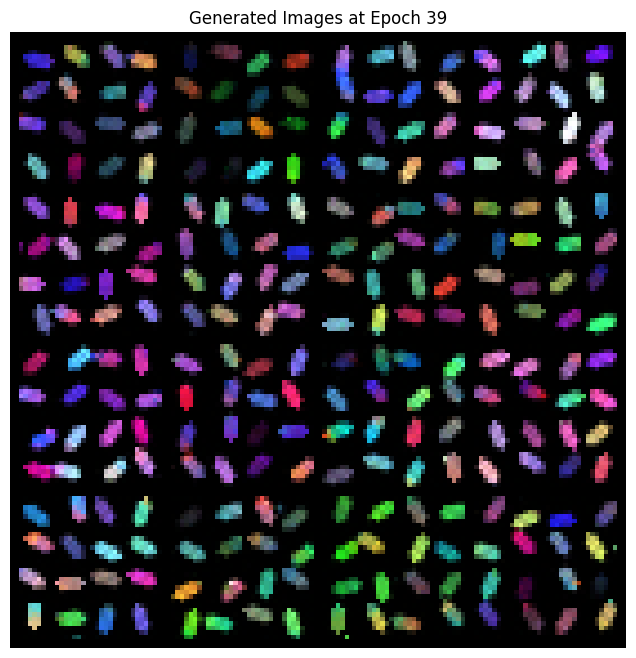

2025-07-07 15:03:33 - INFO - ------------------------------
2025-07-07 15:03:36 - INFO - Epoch: 40/60 | Batch: 0/176 | Loss (NLL): -12932.9297 | BPD: 1.9263
2025-07-07 15:05:13 - INFO - Epoch: 40/60 | Batch: 50/176 | Loss (NLL): -12764.2705 | BPD: 2.0056
2025-07-07 15:06:50 - INFO - Epoch: 40/60 | Batch: 100/176 | Loss (NLL): -12735.2285 | BPD: 2.0192
2025-07-07 15:08:27 - INFO - Epoch: 40/60 | Batch: 150/176 | Loss (NLL): -12945.4326 | BPD: 1.9205
2025-07-07 15:09:15 - INFO - --- Epoch 40 Summary ---
2025-07-07 15:09:15 - INFO - Average Loss: -12790.4596 | Time: 341.90s
2025-07-07 15:09:15 - INFO - Generating sample images...


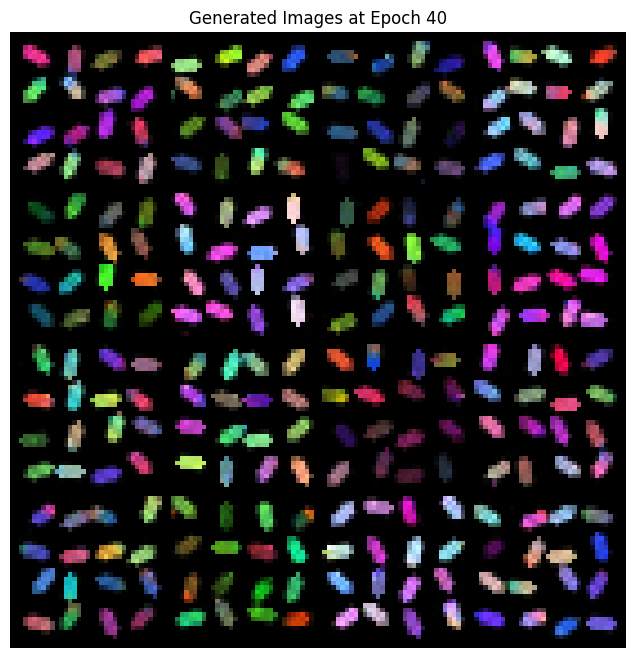

2025-07-07 15:09:15 - INFO - ------------------------------
2025-07-07 15:09:18 - INFO - Epoch: 41/60 | Batch: 0/176 | Loss (NLL): -12913.0566 | BPD: 1.9357
2025-07-07 15:10:56 - INFO - Epoch: 41/60 | Batch: 50/176 | Loss (NLL): -12886.1523 | BPD: 1.9483
2025-07-07 15:12:33 - INFO - Epoch: 41/60 | Batch: 100/176 | Loss (NLL): -12761.0977 | BPD: 2.0070
2025-07-07 15:14:10 - INFO - Epoch: 41/60 | Batch: 150/176 | Loss (NLL): -12788.1455 | BPD: 1.9943
2025-07-07 15:14:59 - INFO - --- Epoch 41 Summary ---
2025-07-07 15:14:59 - INFO - Average Loss: -12760.0595 | Time: 343.15s
2025-07-07 15:14:59 - INFO - Generating sample images...


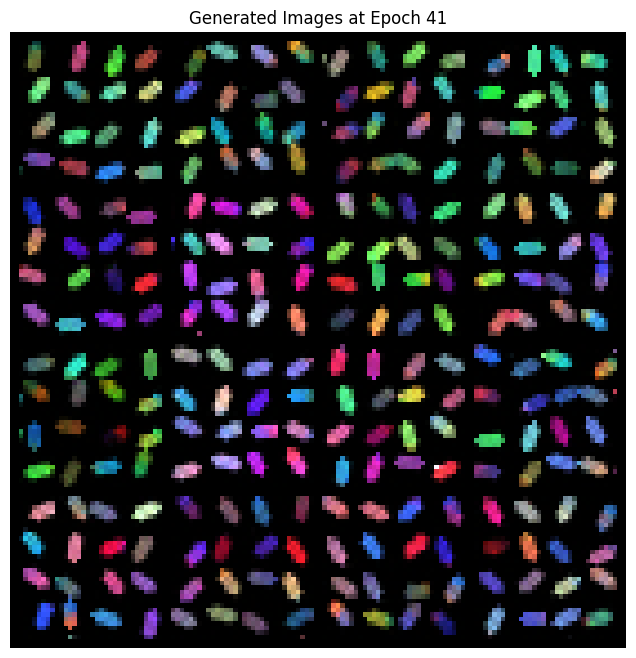

2025-07-07 15:14:59 - INFO - ------------------------------
2025-07-07 15:15:02 - INFO - Epoch: 42/60 | Batch: 0/176 | Loss (NLL): -13041.3906 | BPD: 1.8754
2025-07-07 15:16:39 - INFO - Epoch: 42/60 | Batch: 50/176 | Loss (NLL): -13072.9658 | BPD: 1.8606
2025-07-07 15:18:17 - INFO - Epoch: 42/60 | Batch: 100/176 | Loss (NLL): -12554.5254 | BPD: 2.1041
2025-07-07 15:19:54 - INFO - Epoch: 42/60 | Batch: 150/176 | Loss (NLL): -12923.1641 | BPD: 1.9309
2025-07-07 15:20:42 - INFO - --- Epoch 42 Summary ---
2025-07-07 15:20:42 - INFO - Average Loss: -12776.4196 | Time: 343.12s
2025-07-07 15:20:42 - INFO - Generating sample images...


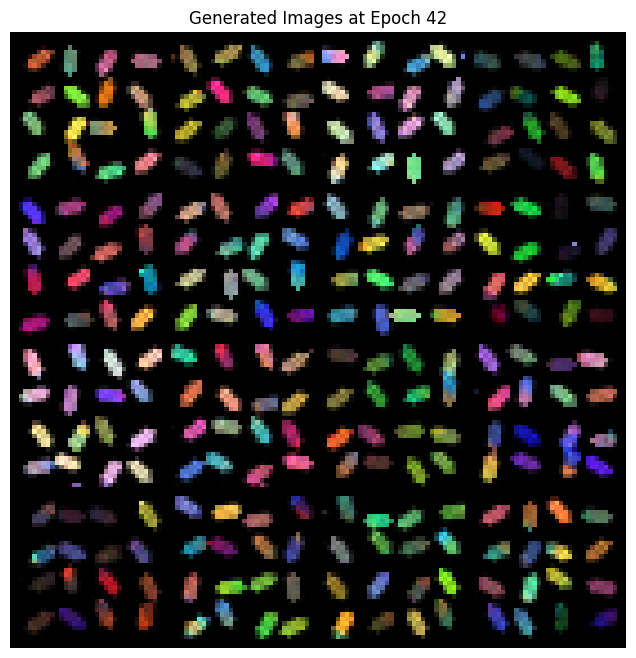

2025-07-07 15:20:43 - INFO - ------------------------------
2025-07-07 15:20:45 - INFO - Epoch: 43/60 | Batch: 0/176 | Loss (NLL): -12444.3809 | BPD: 2.1558
2025-07-07 15:22:22 - INFO - Epoch: 43/60 | Batch: 50/176 | Loss (NLL): -12962.9414 | BPD: 1.9122
2025-07-07 15:23:59 - INFO - Epoch: 43/60 | Batch: 100/176 | Loss (NLL): -12678.8291 | BPD: 2.0457
2025-07-07 15:25:37 - INFO - Epoch: 43/60 | Batch: 150/176 | Loss (NLL): -13071.2051 | BPD: 1.8614
2025-07-07 15:26:25 - INFO - --- Epoch 43 Summary ---
2025-07-07 15:26:25 - INFO - Average Loss: -12806.0382 | Time: 342.79s
2025-07-07 15:26:25 - INFO - Generating sample images...


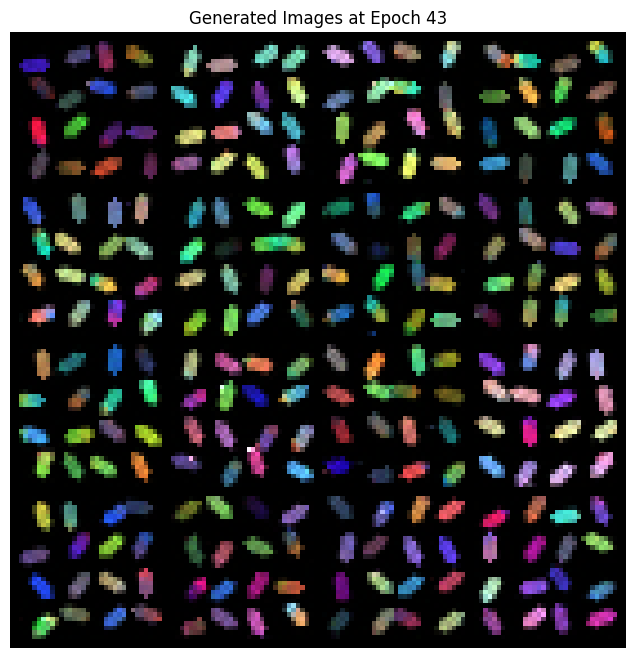

2025-07-07 15:26:26 - INFO - ------------------------------
2025-07-07 15:26:29 - INFO - Epoch: 44/60 | Batch: 0/176 | Loss (NLL): -12928.8848 | BPD: 1.9282
2025-07-07 15:28:07 - INFO - Epoch: 44/60 | Batch: 50/176 | Loss (NLL): -12665.5098 | BPD: 2.0519
2025-07-07 15:29:44 - INFO - Epoch: 44/60 | Batch: 100/176 | Loss (NLL): -12946.3281 | BPD: 1.9201
2025-07-07 15:31:21 - INFO - Epoch: 44/60 | Batch: 150/176 | Loss (NLL): -12920.2734 | BPD: 1.9323
2025-07-07 15:32:10 - INFO - --- Epoch 44 Summary ---
2025-07-07 15:32:10 - INFO - Average Loss: -12915.9475 | Time: 344.59s
2025-07-07 15:32:10 - INFO - Generating sample images...


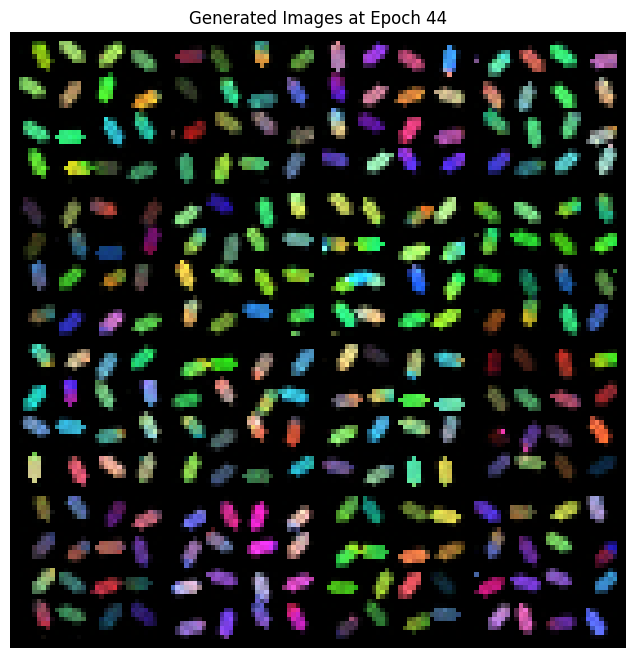

2025-07-07 15:32:11 - INFO - ------------------------------
2025-07-07 15:32:13 - INFO - Epoch: 45/60 | Batch: 0/176 | Loss (NLL): -13028.8730 | BPD: 1.8813
2025-07-07 15:33:50 - INFO - Epoch: 45/60 | Batch: 50/176 | Loss (NLL): -12776.5957 | BPD: 1.9998
2025-07-07 15:35:27 - INFO - Epoch: 45/60 | Batch: 100/176 | Loss (NLL): -12941.8477 | BPD: 1.9222
2025-07-07 15:37:04 - INFO - Epoch: 45/60 | Batch: 150/176 | Loss (NLL): -12914.2598 | BPD: 1.9351
2025-07-07 15:37:53 - INFO - --- Epoch 45 Summary ---
2025-07-07 15:37:53 - INFO - Average Loss: -12949.7206 | Time: 341.77s
2025-07-07 15:37:53 - INFO - Generating sample images...


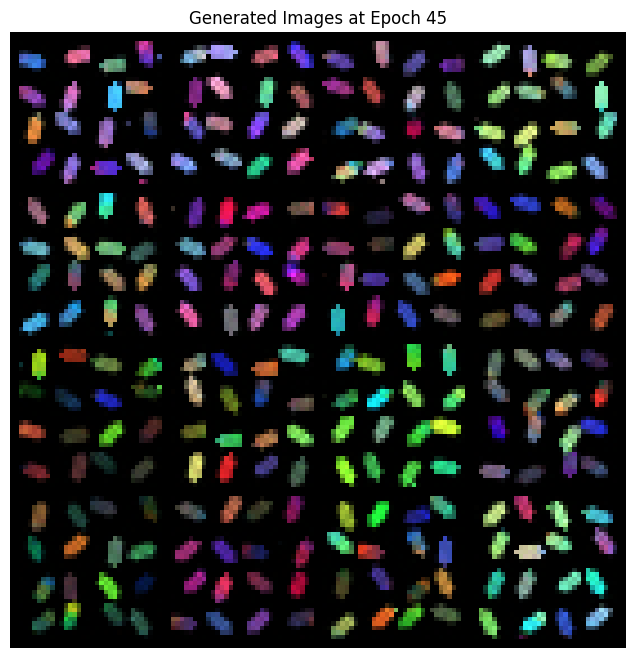

2025-07-07 15:37:53 - INFO - ------------------------------
2025-07-07 15:37:56 - INFO - Epoch: 46/60 | Batch: 0/176 | Loss (NLL): -13061.1055 | BPD: 1.8661
2025-07-07 15:39:33 - INFO - Epoch: 46/60 | Batch: 50/176 | Loss (NLL): -12881.0176 | BPD: 1.9507
2025-07-07 15:41:10 - INFO - Epoch: 46/60 | Batch: 100/176 | Loss (NLL): -13017.0059 | BPD: 1.8869
2025-07-07 15:42:48 - INFO - Epoch: 46/60 | Batch: 150/176 | Loss (NLL): -12896.4766 | BPD: 1.9435
2025-07-07 15:43:36 - INFO - --- Epoch 46 Summary ---
2025-07-07 15:43:36 - INFO - Average Loss: -12914.6467 | Time: 343.14s
2025-07-07 15:43:36 - INFO - Generating sample images...


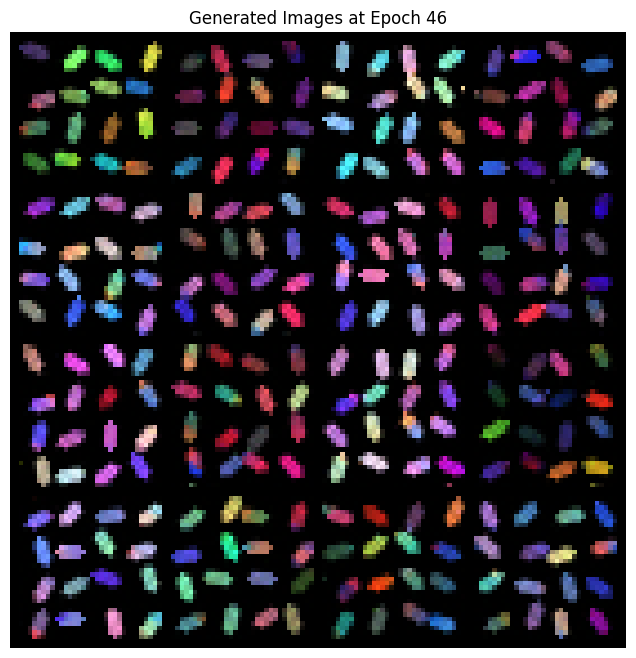

2025-07-07 15:43:37 - INFO - ------------------------------
2025-07-07 15:43:40 - INFO - Epoch: 47/60 | Batch: 0/176 | Loss (NLL): -12752.8867 | BPD: 2.0109
2025-07-07 15:45:16 - INFO - Epoch: 47/60 | Batch: 50/176 | Loss (NLL): -12781.5000 | BPD: 1.9975
2025-07-07 15:46:53 - INFO - Epoch: 47/60 | Batch: 100/176 | Loss (NLL): -13111.1748 | BPD: 1.8426
2025-07-07 15:48:31 - INFO - Epoch: 47/60 | Batch: 150/176 | Loss (NLL): -13009.5410 | BPD: 1.8904
2025-07-07 15:49:19 - INFO - --- Epoch 47 Summary ---
2025-07-07 15:49:19 - INFO - Average Loss: -12947.4206 | Time: 342.21s
2025-07-07 15:49:19 - INFO - Generating sample images...


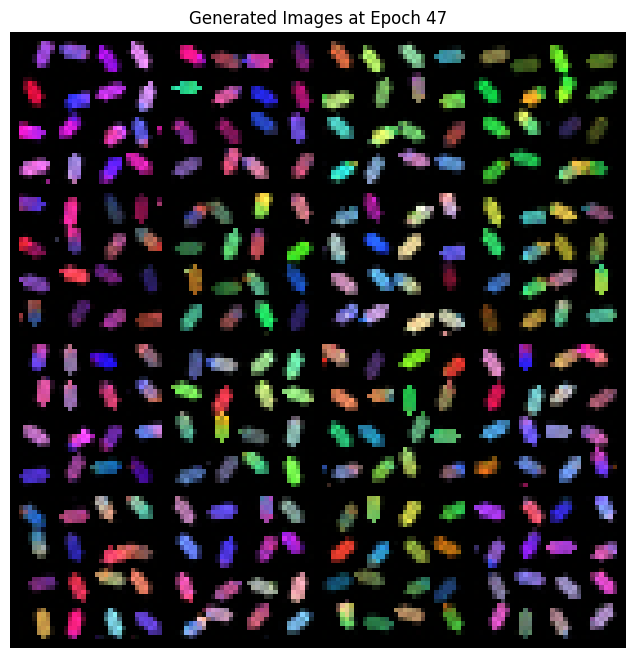

2025-07-07 15:49:19 - INFO - ------------------------------
2025-07-07 15:49:22 - INFO - Epoch: 48/60 | Batch: 0/176 | Loss (NLL): -13200.5400 | BPD: 1.8007
2025-07-07 15:50:59 - INFO - Epoch: 48/60 | Batch: 50/176 | Loss (NLL): -13070.5625 | BPD: 1.8617
2025-07-07 15:52:36 - INFO - Epoch: 48/60 | Batch: 100/176 | Loss (NLL): -13009.8672 | BPD: 1.8902
2025-07-07 15:54:14 - INFO - Epoch: 48/60 | Batch: 150/176 | Loss (NLL): -13042.5576 | BPD: 1.8749
2025-07-07 15:55:03 - INFO - --- Epoch 48 Summary ---
2025-07-07 15:55:03 - INFO - Average Loss: -12989.5251 | Time: 343.42s
2025-07-07 15:55:03 - INFO - Generating sample images...


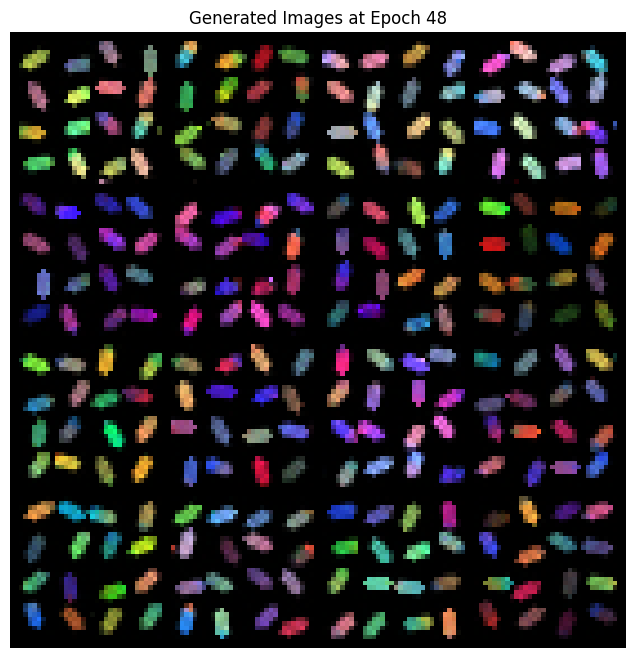

2025-07-07 15:55:03 - INFO - ------------------------------
2025-07-07 15:55:06 - INFO - Epoch: 49/60 | Batch: 0/176 | Loss (NLL): -12848.2715 | BPD: 1.9661
2025-07-07 15:56:43 - INFO - Epoch: 49/60 | Batch: 50/176 | Loss (NLL): -13195.5967 | BPD: 1.8030
2025-07-07 15:58:20 - INFO - Epoch: 49/60 | Batch: 100/176 | Loss (NLL): -12826.3633 | BPD: 1.9764
2025-07-07 15:59:57 - INFO - Epoch: 49/60 | Batch: 150/176 | Loss (NLL): -12687.2480 | BPD: 2.0417
2025-07-07 16:00:46 - INFO - --- Epoch 49 Summary ---
2025-07-07 16:00:46 - INFO - Average Loss: -12950.5997 | Time: 342.55s
2025-07-07 16:00:46 - INFO - Generating sample images...


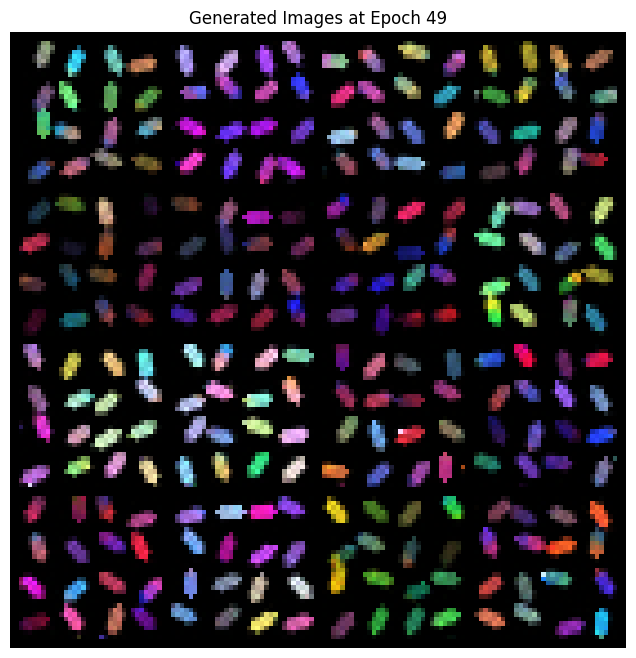

2025-07-07 16:00:46 - INFO - ------------------------------
2025-07-07 16:00:49 - INFO - Epoch: 50/60 | Batch: 0/176 | Loss (NLL): -13141.4883 | BPD: 1.8284
2025-07-07 16:02:26 - INFO - Epoch: 50/60 | Batch: 50/176 | Loss (NLL): -13170.6621 | BPD: 1.8147
2025-07-07 16:04:03 - INFO - Epoch: 50/60 | Batch: 100/176 | Loss (NLL): -12883.6836 | BPD: 1.9495
2025-07-07 16:05:41 - INFO - Epoch: 50/60 | Batch: 150/176 | Loss (NLL): -13146.1348 | BPD: 1.8262
2025-07-07 16:06:30 - INFO - --- Epoch 50 Summary ---
2025-07-07 16:06:30 - INFO - Average Loss: -13005.9007 | Time: 343.66s
2025-07-07 16:06:30 - INFO - Generating sample images...


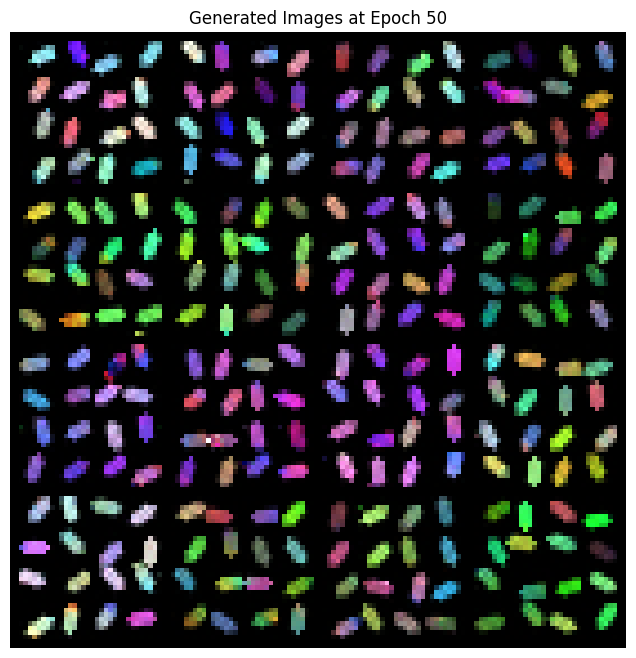

2025-07-07 16:06:30 - INFO - ------------------------------
2025-07-07 16:06:33 - INFO - Epoch: 51/60 | Batch: 0/176 | Loss (NLL): -12963.6416 | BPD: 1.9119
2025-07-07 16:08:12 - INFO - Epoch: 51/60 | Batch: 50/176 | Loss (NLL): -13148.5029 | BPD: 1.8251
2025-07-07 16:09:51 - INFO - Epoch: 51/60 | Batch: 100/176 | Loss (NLL): -13311.1406 | BPD: 1.7487
2025-07-07 16:11:28 - INFO - Epoch: 51/60 | Batch: 150/176 | Loss (NLL): -12804.8086 | BPD: 1.9865
2025-07-07 16:12:17 - INFO - --- Epoch 51 Summary ---
2025-07-07 16:12:17 - INFO - Average Loss: -13105.0627 | Time: 346.95s
2025-07-07 16:12:17 - INFO - Generating sample images...


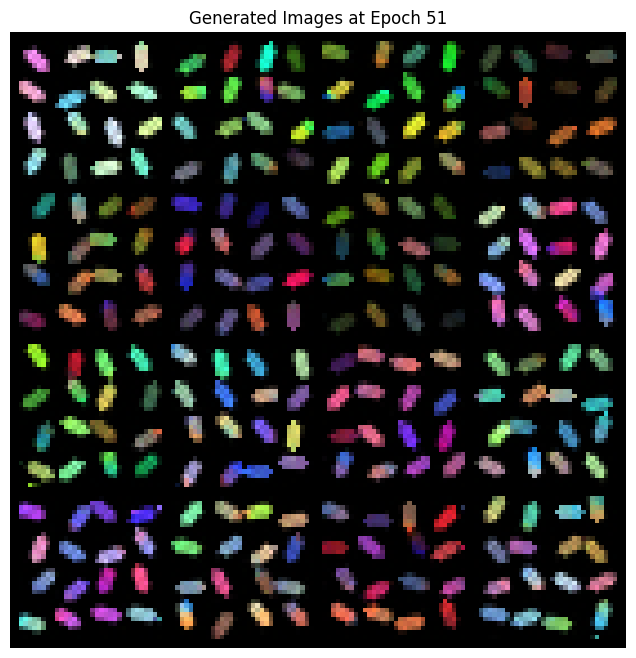

2025-07-07 16:12:18 - INFO - ------------------------------
2025-07-07 16:12:21 - INFO - Epoch: 52/60 | Batch: 0/176 | Loss (NLL): -13129.4824 | BPD: 1.8340
2025-07-07 16:13:58 - INFO - Epoch: 52/60 | Batch: 50/176 | Loss (NLL): -13145.1553 | BPD: 1.8267
2025-07-07 16:15:35 - INFO - Epoch: 52/60 | Batch: 100/176 | Loss (NLL): -13136.5107 | BPD: 1.8307
2025-07-07 16:17:12 - INFO - Epoch: 52/60 | Batch: 150/176 | Loss (NLL): -13223.8779 | BPD: 1.7897
2025-07-07 16:18:01 - INFO - --- Epoch 52 Summary ---
2025-07-07 16:18:01 - INFO - Average Loss: -13067.8793 | Time: 343.51s
2025-07-07 16:18:01 - INFO - Generating sample images...


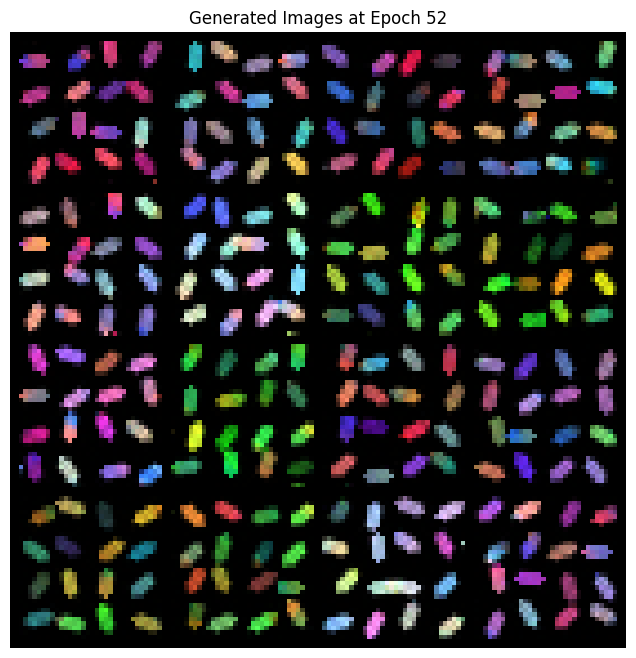

2025-07-07 16:18:01 - INFO - ------------------------------
2025-07-07 16:18:04 - INFO - Epoch: 53/60 | Batch: 0/176 | Loss (NLL): -13217.1846 | BPD: 1.7928
2025-07-07 16:19:42 - INFO - Epoch: 53/60 | Batch: 50/176 | Loss (NLL): -13176.5176 | BPD: 1.8119
2025-07-07 16:21:20 - INFO - Epoch: 53/60 | Batch: 100/176 | Loss (NLL): -13114.6328 | BPD: 1.8410
2025-07-07 16:22:57 - INFO - Epoch: 53/60 | Batch: 150/176 | Loss (NLL): -12761.7314 | BPD: 2.0067
2025-07-07 16:23:45 - INFO - --- Epoch 53 Summary ---
2025-07-07 16:23:45 - INFO - Average Loss: -13144.7856 | Time: 343.92s
2025-07-07 16:23:45 - INFO - Generating sample images...


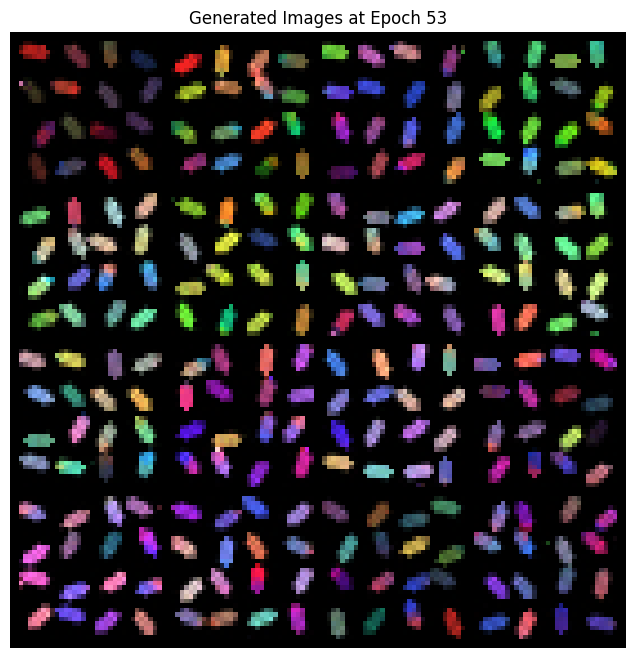

2025-07-07 16:23:46 - INFO - ------------------------------
2025-07-07 16:23:48 - INFO - Epoch: 54/60 | Batch: 0/176 | Loss (NLL): -13259.4375 | BPD: 1.7730
2025-07-07 16:25:26 - INFO - Epoch: 54/60 | Batch: 50/176 | Loss (NLL): -13013.3213 | BPD: 1.8886
2025-07-07 16:27:02 - INFO - Epoch: 54/60 | Batch: 100/176 | Loss (NLL): -13076.7646 | BPD: 1.8588
2025-07-07 16:28:40 - INFO - Epoch: 54/60 | Batch: 150/176 | Loss (NLL): -13194.5527 | BPD: 1.8035
2025-07-07 16:29:28 - INFO - --- Epoch 54 Summary ---
2025-07-07 16:29:28 - INFO - Average Loss: -13135.6223 | Time: 342.24s
2025-07-07 16:29:28 - INFO - Generating sample images...


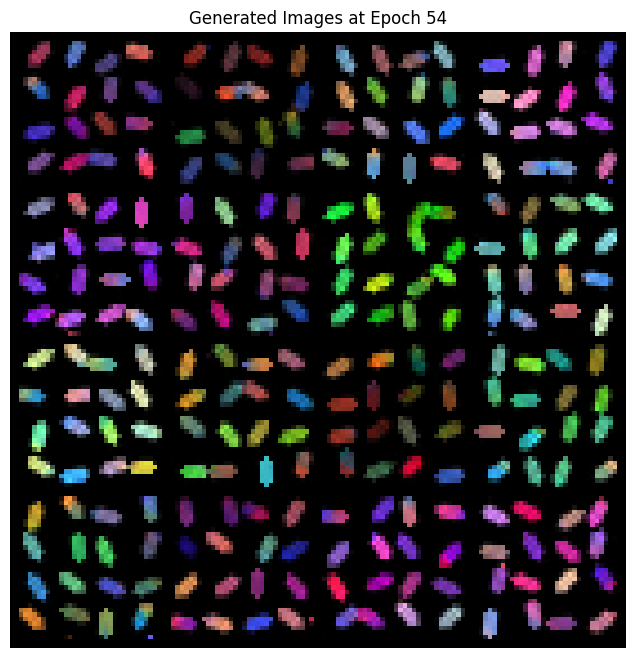

2025-07-07 16:29:28 - INFO - ------------------------------
2025-07-07 16:29:31 - INFO - Epoch: 55/60 | Batch: 0/176 | Loss (NLL): -13377.7383 | BPD: 1.7174
2025-07-07 16:31:09 - INFO - Epoch: 55/60 | Batch: 50/176 | Loss (NLL): -12890.3965 | BPD: 1.9463
2025-07-07 16:32:46 - INFO - Epoch: 55/60 | Batch: 100/176 | Loss (NLL): -13244.3584 | BPD: 1.7801
2025-07-07 16:34:23 - INFO - Epoch: 55/60 | Batch: 150/176 | Loss (NLL): -13074.4590 | BPD: 1.8599
2025-07-07 16:35:11 - INFO - --- Epoch 55 Summary ---
2025-07-07 16:35:11 - INFO - Average Loss: -13134.6836 | Time: 342.48s
2025-07-07 16:35:11 - INFO - Generating sample images...


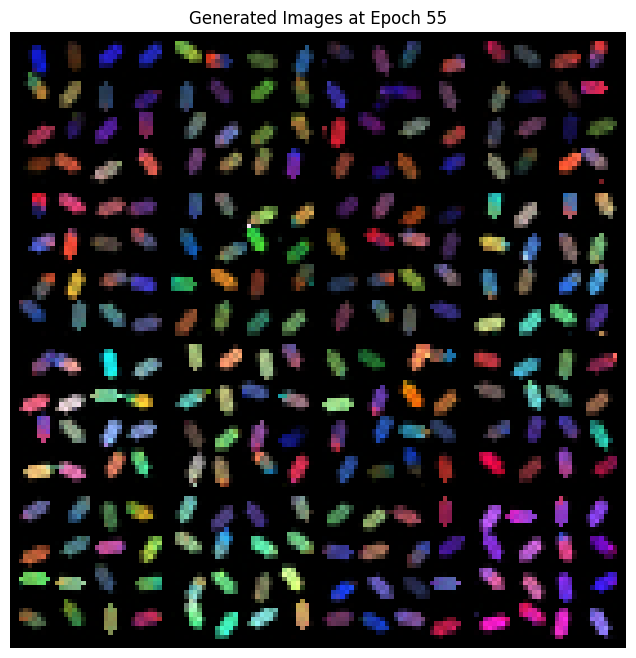

2025-07-07 16:35:11 - INFO - ------------------------------
2025-07-07 16:35:14 - INFO - Epoch: 56/60 | Batch: 0/176 | Loss (NLL): -13104.2363 | BPD: 1.8459
2025-07-07 16:36:52 - INFO - Epoch: 56/60 | Batch: 50/176 | Loss (NLL): -13097.9941 | BPD: 1.8488
2025-07-07 16:38:29 - INFO - Epoch: 56/60 | Batch: 100/176 | Loss (NLL): -13137.4805 | BPD: 1.8303
2025-07-07 16:40:06 - INFO - Epoch: 56/60 | Batch: 150/176 | Loss (NLL): -13217.6846 | BPD: 1.7926
2025-07-07 16:40:54 - INFO - --- Epoch 56 Summary ---
2025-07-07 16:40:54 - INFO - Average Loss: -13132.7416 | Time: 342.72s
2025-07-07 16:40:54 - INFO - Generating sample images...


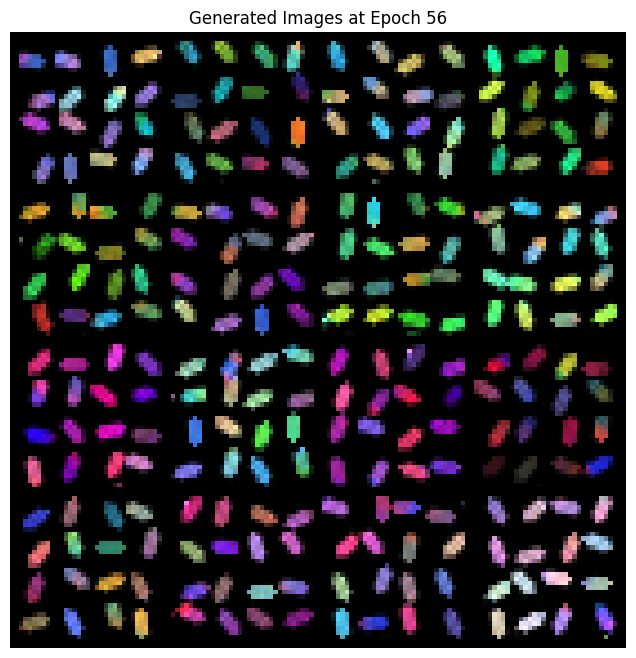

2025-07-07 16:40:55 - INFO - ------------------------------
2025-07-07 16:40:58 - INFO - Epoch: 57/60 | Batch: 0/176 | Loss (NLL): -13002.1240 | BPD: 1.8938
2025-07-07 16:42:35 - INFO - Epoch: 57/60 | Batch: 50/176 | Loss (NLL): -13013.0371 | BPD: 1.8887
2025-07-07 16:44:13 - INFO - Epoch: 57/60 | Batch: 100/176 | Loss (NLL): -13026.3486 | BPD: 1.8825
2025-07-07 16:45:51 - INFO - Epoch: 57/60 | Batch: 150/176 | Loss (NLL): -13046.4326 | BPD: 1.8730
2025-07-07 16:46:39 - INFO - --- Epoch 57 Summary ---
2025-07-07 16:46:39 - INFO - Average Loss: -13181.4478 | Time: 344.73s
2025-07-07 16:46:39 - INFO - Generating sample images...


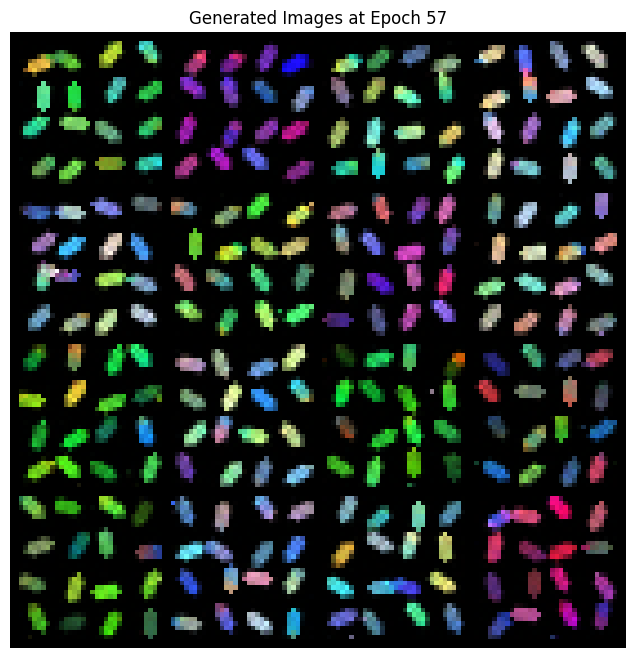

2025-07-07 16:46:40 - INFO - ------------------------------
2025-07-07 16:46:43 - INFO - Epoch: 58/60 | Batch: 0/176 | Loss (NLL): -12819.9199 | BPD: 1.9794
2025-07-07 16:48:20 - INFO - Epoch: 58/60 | Batch: 50/176 | Loss (NLL): -13281.6074 | BPD: 1.7626
2025-07-07 16:49:57 - INFO - Epoch: 58/60 | Batch: 100/176 | Loss (NLL): -13134.1152 | BPD: 1.8319
2025-07-07 16:51:34 - INFO - Epoch: 58/60 | Batch: 150/176 | Loss (NLL): -13333.6523 | BPD: 1.7382
2025-07-07 16:52:23 - INFO - --- Epoch 58 Summary ---
2025-07-07 16:52:23 - INFO - Average Loss: -13202.7382 | Time: 342.88s
2025-07-07 16:52:23 - INFO - Generating sample images...


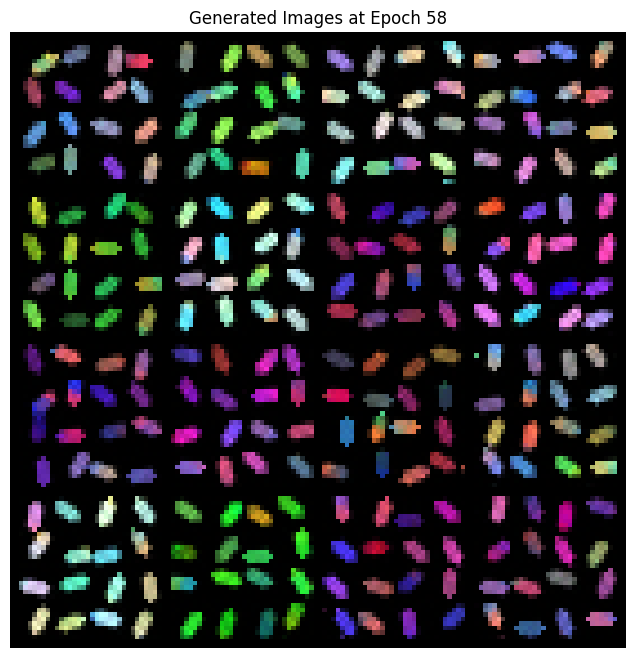

2025-07-07 16:52:23 - INFO - ------------------------------
2025-07-07 16:52:26 - INFO - Epoch: 59/60 | Batch: 0/176 | Loss (NLL): -13174.9258 | BPD: 1.8127
2025-07-07 16:54:03 - INFO - Epoch: 59/60 | Batch: 50/176 | Loss (NLL): -13002.0430 | BPD: 1.8939
2025-07-07 16:55:40 - INFO - Epoch: 59/60 | Batch: 100/176 | Loss (NLL): -13346.5820 | BPD: 1.7321
2025-07-07 16:57:17 - INFO - Epoch: 59/60 | Batch: 150/176 | Loss (NLL): -13246.0840 | BPD: 1.7793
2025-07-07 16:58:06 - INFO - --- Epoch 59 Summary ---
2025-07-07 16:58:06 - INFO - Average Loss: -13232.7707 | Time: 342.76s
2025-07-07 16:58:06 - INFO - Generating sample images...


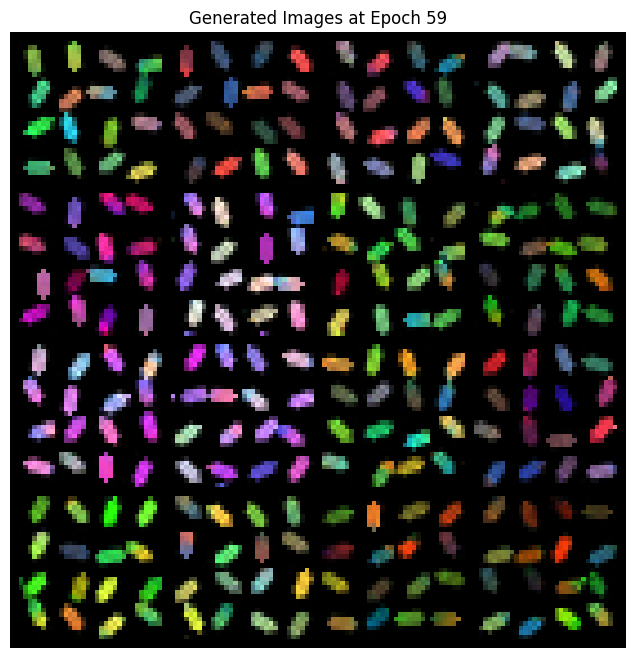

2025-07-07 16:58:06 - INFO - ------------------------------
2025-07-07 16:58:09 - INFO - Epoch: 60/60 | Batch: 0/176 | Loss (NLL): -13206.4023 | BPD: 1.7979
2025-07-07 16:59:46 - INFO - Epoch: 60/60 | Batch: 50/176 | Loss (NLL): -13399.6895 | BPD: 1.7071
2025-07-07 17:01:25 - INFO - Epoch: 60/60 | Batch: 100/176 | Loss (NLL): -13155.4023 | BPD: 1.8219
2025-07-07 17:03:03 - INFO - Epoch: 60/60 | Batch: 150/176 | Loss (NLL): -13082.2383 | BPD: 1.8562
2025-07-07 17:03:51 - INFO - --- Epoch 60 Summary ---
2025-07-07 17:03:51 - INFO - Average Loss: -13262.7536 | Time: 345.17s
2025-07-07 17:03:51 - INFO - Generating sample images...


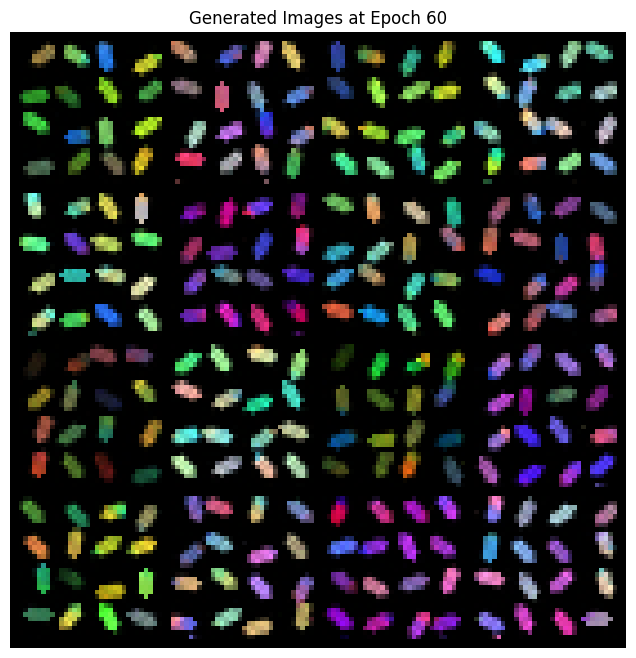

2025-07-07 17:03:52 - INFO - ------------------------------


In [ ]:
IMAGE_SIZE = 32
NUM_CHANNELS = 3
BATCH_SIZE = batch_size
LEARNING_RATE = 1e-3
NUM_EPOCHS = 60
prior_str = "gaussian"
prior = PriorDistribution(dist_type=prior_str)


logger = setup_logger()
optimizer = torch.optim.AdamW(flow.parameters(), lr=LEARNING_RATE, weight_decay=5e-5)

try:
    train_rg_flow(
        model=flow,
        prior=prior,
        train_loader=train_loader,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=DEVICE,
        image_dims=(NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE),
        logger=logger,
        num_images_to_generate=16
    )
except Exception as e:
    logger.error("An error occurred during training!", exc_info=True)

In [ ]:
from google.colab import files
!zip -r generated_images.zip generated_images
files.download('generated_images.zip')
# Download the model weights file

  adding: generated_images/ (stored 0%)
  adding: generated_images/epoch_037.png (deflated 9%)
  adding: generated_images/epoch_022.png (deflated 9%)
  adding: generated_images/epoch_051.png (deflated 9%)
  adding: generated_images/epoch_052.png (deflated 9%)
  adding: generated_images/epoch_036.png (deflated 9%)
  adding: generated_images/epoch_043.png (deflated 9%)
  adding: generated_images/epoch_002.png (deflated 9%)
  adding: generated_images/epoch_047.png (deflated 9%)
  adding: generated_images/epoch_028.png (deflated 9%)
  adding: generated_images/epoch_048.png (deflated 9%)
  adding: generated_images/epoch_050.png (deflated 9%)
  adding: generated_images/epoch_029.png (deflated 9%)
  adding: generated_images/epoch_005.png (deflated 9%)
  adding: generated_images/epoch_055.png (deflated 9%)
  adding: generated_images/epoch_040.png (deflated 9%)
  adding: generated_images/epoch_042.png (deflated 9%)
  adding: generated_images/epoch_056.png (deflated 9%)
  adding: generated_image

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

from datetime import datetime

# Create a timestamp for the filename
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
MODEL_WEIGHTS_PATH = f"rg_flow_weights_{timestamp}_{NUM_EPOCHS}_MSD1_{prior_str}.pth"

print(f"Saving model weights to {MODEL_WEIGHTS_PATH}...")

# Use model.state_dict() to get the dictionary of weights
torch.save(flow.state_dict(), MODEL_WEIGHTS_PATH)

print("Model weights saved successfully.")
files.download(MODEL_WEIGHTS_PATH)

Saving model weights to rg_flow_weights_2025-07-07_17-03-52_60_MSD1_gaussian.pth...
Model weights saved successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# Define the path for saving the optimizer state
optimizer_path = f"rg_flow_optimizer_{timestamp}_{NUM_EPOCHS}_MSD1_{prior_str}.pth"

print(f"Saving optimizer state to {optimizer_path}...")

# Save the state_dict of the optimizer
torch.save(optimizer.state_dict(), optimizer_path)

print("Optimizer state saved successfully.")

# Download the optimizer state file
files.download(optimizer_path)

Saving optimizer state to rg_flow_optimizer_2025-07-07_17-03-52_60_MSD1_gaussian.pth...
Optimizer state saved successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>